In [ ]:
# @title 1. Install Dependencies
# We use pymoo for the NSGA-II algorithm implementation
!pip install pymoo pandas matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
# @title 2. Define Project Data & Logic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination

# --- DATA INPUT (Based on Table 2) ---
# Structure: Activity ID -> [Predecessors], List of Modes
# Mode: {Duration, Cost, Quality, R1, R2, R3}

activities = {
    1: {'pred': [], 'modes': [
        {'id': 1, 'dur': 2, 'cost': 1000, 'q': 0.80, 'r': [0, 2, 0]}
    ]},
    2: {'pred': [1], 'modes': [
        {'id': 1, 'dur': 14, 'cost': 1260, 'q': 0.78, 'r': [0, 3, 1]},
        {'id': 2, 'dur': 10, 'cost': 1220, 'q': 0.80, 'r': [0, 7, 1]},
        {'id': 3, 'dur': 8, 'cost': 1376, 'q': 0.83, 'r': [0, 5, 2]},
        {'id': 4, 'dur': 7, 'cost': 1022, 'q': 0.82, 'r': [0, 10, 1]},
        {'id': 5, 'dur': 12, 'cost': 1464, 'q': 0.84, 'r': [0, 7, 1]},
        {'id': 6, 'dur': 10, 'cost': 1720, 'q': 0.87, 'r': [0, 5, 2]},
        {'id': 7, 'dur': 10, 'cost': 1460, 'q': 0.88, 'r': [0, 10, 1]}
    ]},
    3: {'pred': [2], 'modes': [
        {'id': 1, 'dur': 25, 'cost': 400, 'q': 0.74, 'r': [0, 2, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 16, 'cost': 896, 'q': 0.83, 'r': [0, 7, 0]},
        {'id': 4, 'dur': 12, 'cost': 960, 'q': 0.90, 'r': [0, 10, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 18, 'cost': 1008, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 7, 'dur': 14, 'cost': 1120, 'q': 0.92, 'r': [0, 10, 0]}
    ]},
    4: {'pred': [1, 2], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 160, 'q': 0.77, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 4, 'cost': 224, 'q': 0.80, 'r': [0, 7, 0]},
        {'id': 3, 'dur': 3, 'cost': 240, 'q': 0.83, 'r': [0, 10, 0]},
        {'id': 4, 'dur': 2, 'cost': 208, 'q': 0.86, 'r': [0, 13, 0]},
        {'id': 5, 'dur': 5, 'cost': 280, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 6, 'dur': 4, 'cost': 320, 'q': 0.88, 'r': [0, 10, 0]},
        {'id': 7, 'dur': 3, 'cost': 312, 'q': 0.90, 'r': [0, 13, 0]}
    ]},
    5: {'pred': [3], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 570, 'q': 0.76, 'r': [1, 3, 1]},
        {'id': 2, 'dur': 3, 'cost': 414, 'q': 0.80, 'r': [2, 3, 1]},
        {'id': 3, 'dur': 4, 'cost': 488, 'q': 0.75, 'r': [1, 4, 1]},
        {'id': 4, 'dur': 2, 'cost': 308, 'q': 0.85, 'r': [2, 5, 1]},
        {'id': 5, 'dur': 4, 'cost': 552, 'q': 0.86, 'r': [2, 3, 1]},
        {'id': 6, 'dur': 5, 'cost': 610, 'q': 0.82, 'r': [1, 4, 1]},
        {'id': 7, 'dur': 3, 'cost': 462, 'q': 0.92, 'r': [2, 5, 1]}
    ]},
    6: {'pred': [4, 5], 'modes': [
        {'id': 1, 'dur': 22, 'cost': 704, 'q': 0.78, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 17, 'cost': 816, 'q': 0.81, 'r': [0, 6, 0]},
        {'id': 4, 'dur': 15, 'cost': 840, 'q': 0.82, 'r': [0, 7, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 19, 'cost': 912, 'q': 0.83, 'r': [0, 6, 0]},
        {'id': 7, 'dur': 17, 'cost': 952, 'q': 0.84, 'r': [0, 7, 0]}
    ]},
    7: {'pred': [6], 'modes': [
        {'id': 1, 'dur': 11, 'cost': 880, 'q': 0.82, 'r': [0, 1, 0]},
        {'id': 2, 'dur': 7, 'cost': 112, 'q': 0.80, 'r': [0, 2, 0]},
        {'id': 3, 'dur': 4, 'cost': 96, 'q': 0.81, 'r': [0, 3, 0]},
        {'id': 4, 'dur': 2, 'cost': 64, 'q': 0.84, 'r': [0, 4, 0]},
        {'id': 5, 'dur': 8, 'cost': 128, 'q': 0.83, 'r': [0, 2, 0]},
        {'id': 6, 'dur': 5, 'cost': 120, 'q': 0.83, 'r': [0, 3, 0]},
        {'id': 7, 'dur': 3, 'cost': 96, 'q': 0.87, 'r': [0, 4, 0]}
    ]},
    8: {'pred': [7], 'modes': [
        {'id': 1, 'dur': 19, 'cost': 1216, 'q': 0.82, 'r': [0, 8, 0]},
        {'id': 2, 'dur': 15, 'cost': 1200, 'q': 0.80, 'r': [0, 10, 0]},
        {'id': 3, 'dur': 6, 'cost': 684, 'q': 0.74, 'r': [0, 6, 1]},
        {'id': 4, 'dur': 5, 'cost': 650, 'q': 0.76, 'r': [0, 8, 1]},
        {'id': 5, 'dur': 16, 'cost': 1280, 'q': 0.81, 'r': [0, 10, 0]},
        {'id': 6, 'dur': 7, 'cost': 798, 'q': 0.75, 'r': [0, 6, 1]},
        {'id': 7, 'dur': 6, 'cost': 780, 'q': 0.77, 'r': [0, 8, 1]}
    ]}
}

# --- HELPER FUNCTIONS ---

def calculate_schedule(mode_indices):
    """
    Calculates Start and Finish times based on CPM.
    mode_indices: list where index i corresponds to Activity i+1
    """
    # Initialize Early Start (ES) and Early Finish (EF)
    es = {i: 0 for i in activities}
    ef = {i: 0 for i in activities}

    # Forward Pass
    for i in sorted(activities.keys()):
        mode_idx = mode_indices[i-1]
        duration = activities[i]['modes'][mode_idx]['dur']

        predecessors = activities[i]['pred']
        if not predecessors:
            start_time = 0
        else:
            start_time = max([ef[p] for p in predecessors])

        es[i] = start_time
        ef[i] = start_time + duration

    project_duration = max(ef.values())
    return es, ef, project_duration

def calculate_metrics(mode_indices):
    """
    Calculates Duration, Cost, Quality, and Resource Moments
    """
    # 1. Schedule (Time)
    es, ef, duration = calculate_schedule(mode_indices)

    total_cost = 0
    total_quality = 0

    # Determine Project Horizon for resource array
    horizon = int(duration) + 1
    # 3 Resources (R1, R2, R3)
    resource_profile = np.zeros((3, horizon))

    for i in activities:
        mode_idx = mode_indices[i-1]
        mode_data = activities[i]['modes'][mode_idx]

        # 2. Cost (Sum of direct costs)
        total_cost += mode_data['cost']

        # 3. Quality (Average quality - assuming equal weight for simplicity as per common literature practice unless specified)
        # Equation 10 suggests weighted sum. If weights aren't provided, average is standard.
        total_quality += mode_data['q']

        # 4. Resource Allocation
        start = int(es[i])
        end = int(ef[i])
        r_usage = mode_data['r'] # [r1, r2, r3]

        for day in range(start, end):
            resource_profile[0, day] += r_usage[0]
            resource_profile[1, day] += r_usage[1]
            resource_profile[2, day] += r_usage[2]

    avg_quality = (total_quality / len(activities)) * 100 # Percentage

    # 5. Resource Moments (Eq 11, 12, 13, 14)
    # Mx = 0.5 * Sum(Y^2)
    # My = Sum(Y * (d - 0.5)) - Although standard leveling uses sum of squares (Mx),
    # the paper uses Mtot = Mx + My.

    m_tot = 0
    for r in range(3): # For each resource
        daily_usage = resource_profile[r, :int(duration)]

        # Mx (Smoothing)
        mx = 0.5 * np.sum(daily_usage ** 2)

        # My (Compactness/Time moment)
        days = np.arange(1, len(daily_usage) + 1)
        my = np.sum(daily_usage * (days - 0.5))

        m_tot += (mx + my)

    return duration, total_cost, avg_quality, m_tot

# --- PYMOO PROBLEM DEFINITION ---

class ConstructionTradeOff(ElementwiseProblem):
    def __init__(self):
        # 8 variables (activities), Integer bounds
        # Lower bound 0 (index 0 corresponds to Method 1)
        # Upper bounds depend on specific activity method counts
        xl = np.zeros(8)
        xu = np.array([len(activities[i]['modes'])-1 for i in range(1, 9)])

        super().__init__(n_var=8, n_obj=4, n_ieq_constr=0, xl=xl, xu=xu, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        # x is the vector of mode indices (floats/ints)
        mode_indices = x.astype(int)

        d, c, q, r = calculate_metrics(mode_indices)

        # NSGA-II Minimizes.
        # Time -> Min
        # Cost -> Min
        # Quality -> Max (So we return -Quality)
        # Resource Moment -> Min

        out["F"] = [d, c, -q, r] # Note negative Q

print("Logic Defined.")

Logic Defined.


In [ ]:
# @title 3. Run GA Optimization (NSGA-II) [CORRECTED]
# Fixed 'AttributeError: bool object has no attribute do' by removing repair=False

# Import RoundingRepair to ensure integer values for modes
from pymoo.operators.repair.rounding import RoundingRepair

problem = ConstructionTradeOff()

algorithm = NSGA2(
    pop_size=100,
    sampling=IntegerRandomSampling(),
    # We use SBX and PM (Continuous operators) but add RoundingRepair
    # to ensure the floating point calculations map back to valid integer Mode IDs
    crossover=SBX(prob=0.9, eta=15, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=0.05, eta=20, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 500)

print("Starting Optimization... this may take a few seconds.")
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=False,
               verbose=True)

print(f"Optimization finished. found {len(res.F)} non-dominated solutions.")

# Convert results to DataFrame
# Remember to flip Quality back to positive
results_df = pd.DataFrame(res.F, columns=['Duration', 'Cost', 'Quality_Neg', 'Resource_Moment'])
results_df['Quality'] = -results_df['Quality_Neg']
results_df = results_df.drop('Quality_Neg', axis=1)

# Add the design variables (the modes selected)
modes_df = pd.DataFrame(res.X, columns=[f'Act_{i}' for i in range(1, 9)])
# Adjust 0-based index to 1-based for readability
modes_df = modes_df + 1
full_data = pd.concat([results_df, modes_df], axis=1)

full_data.head()

Starting Optimization... this may take a few seconds.
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     15 |             - |             -
     2 |      200 |     22 |  0.0514835229 |         ideal
     3 |      300 |     34 |  0.1666666667 |         ideal
     4 |      400 |     35 |  0.0740740741 |         ideal
     5 |      500 |     32 |  0.1052631579 |         ideal
     6 |      600 |     45 |  0.0230684731 |         ideal
     7 |      700 |     63 |  0.0476190476 |         ideal
     8 |      800 |     72 |  0.1043967075 |         ideal
     9 |      900 |     83 |  0.0454545455 |         ideal
    10 |     1000 |     95 |  0.0350877193 |         ideal
    11 |     1100 |    100 |  0.0363636364 |         nadir
    12 |     1200 |    100 |  0.0163007738 |             f
    13 |     1300 |    100 |  0.0178571429 |         ideal
    14 |     1400 |    100 |  0.0073992541 |             f
    15 |     1500 |    100 |  0.0153727902 |         nadir
  

,Duration,Cost,Resource_Moment,Quality,Act_1,Act_2,Act_3,Act_4,Act_5,Act_6,Act_7,Act_8
0,68.0,6878.0,20851.0,86.750,1,6,7,7,7,7,7,1
1,65.0,6682.0,21911.0,86.750,1,7,7,7,7,7,7,5
2,70.0,6578.0,21671.0,86.750,1,7,7,7,7,6,7,1
3,66.0,4340.0,10880.0,79.875,1,4,1,1,4,1,7,4
4,68.0,6618.0,21491.0,86.875,1,7,7,7,7,7,7,1


In [ ]:
# @title 4. MCDM Decision Making (TOPSIS with OPA Weights)
# Weights derived from Table A2 in the paper
# Duration: 0.304659, Cost: 0.476703, Quality: 0.078853, Resource: 0.139785

def run_topsis(df):
    data = df.copy()

    # 1. Define Weights
    weights = np.array([0.304659, 0.476703, 0.078853, 0.139785])

    # 2. Vector Normalization
    # Sqrt of sum of squares for each column
    norm_data = data / np.sqrt((data**2).sum())

    # 3. Weighted Normalized Matrix
    weighted_data = norm_data * weights

    # 4. Determine Ideal Best (V+) and Ideal Worst (V-)
    # Attributes: [Duration (Min), Cost (Min), Quality (Max), Resource (Min)]
    # Note: In our DF, Quality is positive (0-100).

    # Min attributes
    v_best = [
        weighted_data['Duration'].min(),
        weighted_data['Cost'].min(),
        weighted_data['Quality'].max(),
        weighted_data['Resource_Moment'].min()
    ]

    v_worst = [
        weighted_data['Duration'].max(),
        weighted_data['Cost'].max(),
        weighted_data['Quality'].min(),
        weighted_data['Resource_Moment'].max()
    ]

    # 5. Calculate Euclidean Distances
    # S+ (Distance to Best)
    s_plus = np.sqrt(((weighted_data - v_best)**2).sum(axis=1))

    # S- (Distance to Worst)
    s_minus = np.sqrt(((weighted_data - v_worst)**2).sum(axis=1))

    # 6. Performance Score (Ci)
    ci = s_minus / (s_plus + s_minus)

    return ci

# Run TOPSIS on the Pareto Front
scores = run_topsis(full_data[['Duration', 'Cost', 'Quality', 'Resource_Moment']])
full_data['TOPSIS_Score'] = scores
full_data['Rank'] = full_data['TOPSIS_Score'].rank(ascending=False)

# Get Top Solution
best_solution = full_data.sort_values(by='TOPSIS_Score', ascending=False).iloc[0]

print("--- BEST COMPROMISE SOLUTION (Rank 1) ---")
print(best_solution)

print("\n--- COMPARISON WITH PAPER TABLE 3 (Approximate) ---")
print(f"Paper Best Duration: 47 days | Our Duration: {best_solution['Duration']}")
print(f"Paper Best Cost: $4308 | Our Cost: {full_data['Cost'].min()}")

--- BEST COMPROMISE SOLUTION (Rank 1) ---
Duration              46.000000
Cost                5036.000000
Resource_Moment    10225.000000
Quality               82.375000
Act_1                  1.000000
Act_2                  4.000000
Act_3                  4.000000
Act_4                  1.000000
Act_5                  4.000000
Act_6                  4.000000
Act_7                  7.000000
Act_8                  4.000000
TOPSIS_Score           0.797269
Rank                   1.000000
Name: 37, dtype: float64

--- COMPARISON WITH PAPER TABLE 3 (Approximate) ---
Paper Best Duration: 47 days | Our Duration: 46.0
Paper Best Cost: $4308 | Our Cost: 4340.0


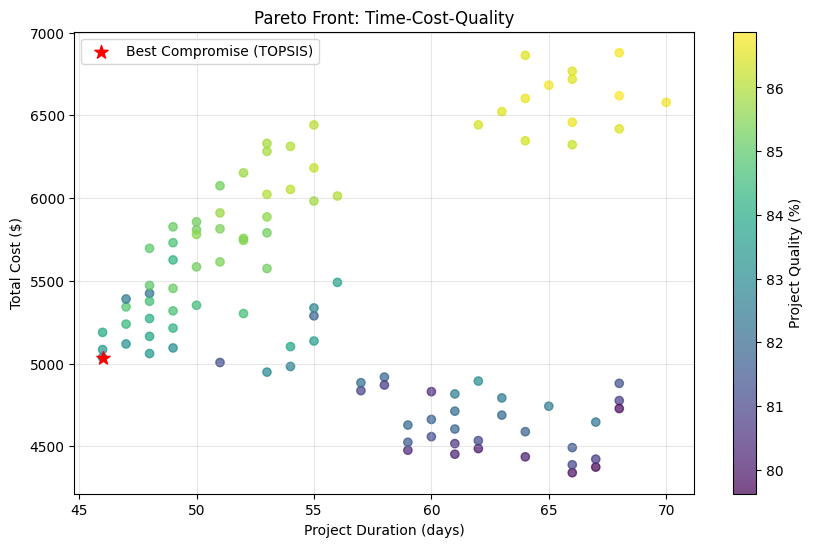

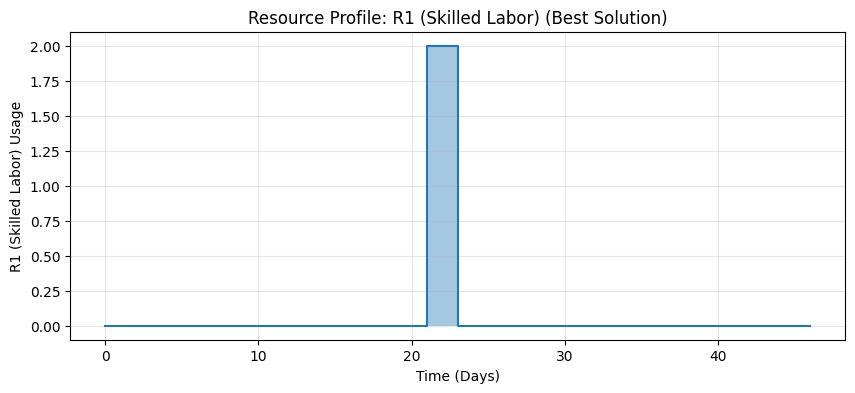

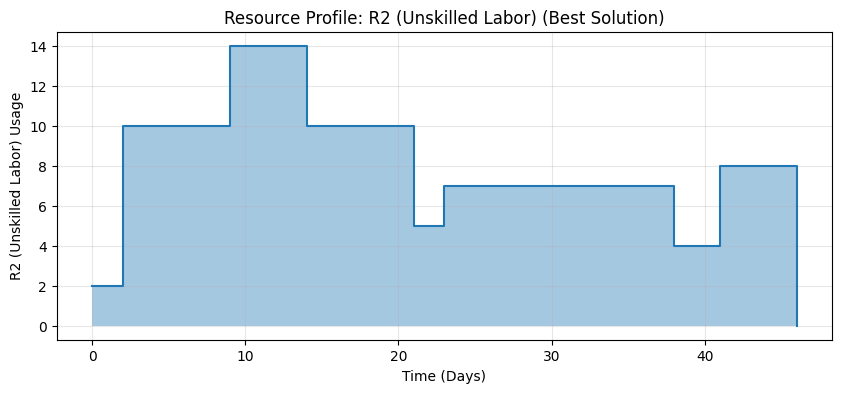

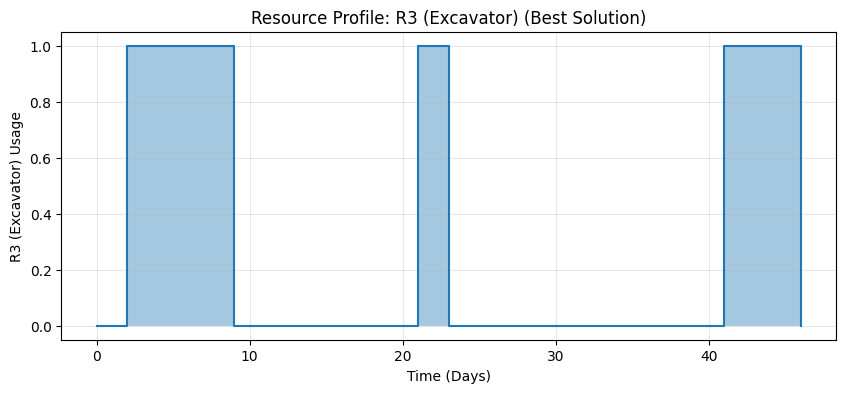

In [ ]:
# @title 5. Visualization of Results

# Plot 1: Cost vs Duration
plt.figure(figsize=(10, 6))
plt.scatter(full_data['Duration'], full_data['Cost'], c=full_data['Quality'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Project Quality (%)')
plt.xlabel('Project Duration (days)')
plt.ylabel('Total Cost ($)')
plt.title('Pareto Front: Time-Cost-Quality')
plt.grid(True, alpha=0.3)

# Highlight Best Solution
plt.scatter(best_solution['Duration'], best_solution['Cost'], color='red', s=100, marker='*', label='Best Compromise (TOPSIS)')
plt.legend()
plt.show()

# Plot 2: Resource Profile for Best Solution
def plot_resource_profile(mode_indices, resource_id, r_name):
    mode_indices = np.array(mode_indices).astype(int)
    # Convert 1-based input back to 0-based for calculation
    mode_indices = mode_indices - 1

    es, ef, duration = calculate_schedule(mode_indices)
    horizon = int(duration) + 1
    profile = np.zeros(horizon)

    for i in activities:
        mode_idx = mode_indices[i-1]
        start = int(es[i])
        end = int(ef[i])
        usage = activities[i]['modes'][mode_idx]['r'][resource_id]
        profile[start:end] += usage

    plt.figure(figsize=(10, 4))
    plt.step(range(horizon), profile, where='post')
    plt.fill_between(range(horizon), profile, step='post', alpha=0.4)
    plt.xlabel('Time (Days)')
    plt.ylabel(f'{r_name} Usage')
    plt.title(f'Resource Profile: {r_name} (Best Solution)')
    plt.grid(True, alpha=0.3)
    plt.show()

# Extract mode indices from best solution
best_modes = best_solution[[f'Act_{i}' for i in range(1, 9)]].values
plot_resource_profile(best_modes, 0, 'R1 (Skilled Labor)')
plot_resource_profile(best_modes, 1, 'R2 (Unskilled Labor)')
plot_resource_profile(best_modes, 2, 'R3 (Excavator)')

In [ ]:
# @title 6. Export to Excel (Practitioner View)
# This creates an Excel file similar to the one described in the paper's "Practical Implications"

# Create a clean dictionary for the Best Solution
best_idx = int(best_solution.name) # Index in the full dataframe
modes_selected = best_solution[[f'Act_{i}' for i in range(1, 9)]].astype(int).tolist()

# Recalculate Schedule details
es, ef, dur = calculate_schedule(np.array(modes_selected) - 1)

schedule_data = []
for i in activities:
    mode_id = modes_selected[i-1]
    # Get specific mode data
    m = activities[i]['modes'][mode_id-1]

    row = {
        'Activity ID': i,
        'Selected Method': mode_id,
        'Duration': m['dur'],
        'Start Day': es[i],
        'Finish Day': ef[i],
        'Cost': m['cost'],
        'Quality': m['q'],
        'R1 (Skilled)': m['r'][0],
        'R2 (Unskilled)': m['r'][1],
        'R3 (Excavator)': m['r'][2]
    }
    schedule_data.append(row)

schedule_df = pd.DataFrame(schedule_data)

# Export
file_name = "Optimized_Construction_Schedule.xlsx"
schedule_df.to_excel(file_name, index=False)
print(f"File saved as {file_name}. You can download it from the files tab on the left.")

# Display the schedule table here
schedule_df

File saved as Optimized_Construction_Schedule.xlsx. You can download it from the files tab on the left.


,Activity ID,Selected Method,Duration,Start Day,Finish Day,Cost,Quality,R1 (Skilled),R2 (Unskilled),R3 (Excavator)
0,1,1,2,0,2,1000,0.80,0,2,0
1,2,4,7,2,9,1022,0.82,0,10,1
2,3,4,12,9,21,960,0.90,0,10,0
3,4,1,5,9,14,160,0.77,0,4,0
4,5,4,2,21,23,308,0.85,2,5,1
5,6,4,15,23,38,840,0.82,0,7,0
6,7,7,3,38,41,96,0.87,0,4,0
7,8,4,5,41,46,650,0.76,0,8,1


In [ ]:
# @title 1. Setup & Advanced Library Installation
!pip install pymoo pandas numpy matplotlib scipy seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
# @title 2. Data Engineering (Stochastic & Green)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# --- PROJECT DATA DEFINITION ---
# Extension of Table 2 from original paper.
# Added: 'co2' (Carbon Kg) and 'std' (Risk/Uncertainty)
activities_data = {
    1: {'pred': [], 'modes': [{'id': 1, 'dur': 2, 'cost': 1000, 'q': 0.80, 'r': [0, 2, 0]}]},
    2: {'pred': [1], 'modes': [
        {'id': 1, 'dur': 14, 'cost': 1260, 'q': 0.78, 'r': [0, 3, 1]},
        {'id': 2, 'dur': 10, 'cost': 1220, 'q': 0.80, 'r': [0, 7, 1]},
        {'id': 3, 'dur': 8, 'cost': 1376, 'q': 0.83, 'r': [0, 5, 2]},
        {'id': 4, 'dur': 7, 'cost': 1022, 'q': 0.82, 'r': [0, 10, 1]},
        {'id': 5, 'dur': 12, 'cost': 1464, 'q': 0.84, 'r': [0, 7, 1]},
        {'id': 6, 'dur': 10, 'cost': 1720, 'q': 0.87, 'r': [0, 5, 2]},
        {'id': 7, 'dur': 10, 'cost': 1460, 'q': 0.88, 'r': [0, 10, 1]}
    ]},
    3: {'pred': [2], 'modes': [
        {'id': 1, 'dur': 25, 'cost': 400, 'q': 0.74, 'r': [0, 2, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 16, 'cost': 896, 'q': 0.83, 'r': [0, 7, 0]},
        {'id': 4, 'dur': 12, 'cost': 960, 'q': 0.90, 'r': [0, 10, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 18, 'cost': 1008, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 7, 'dur': 14, 'cost': 1120, 'q': 0.92, 'r': [0, 10, 0]}
    ]},
    4: {'pred': [1, 2], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 160, 'q': 0.77, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 4, 'cost': 224, 'q': 0.80, 'r': [0, 7, 0]},
        {'id': 3, 'dur': 3, 'cost': 240, 'q': 0.83, 'r': [0, 10, 0]},
        {'id': 4, 'dur': 2, 'cost': 208, 'q': 0.86, 'r': [0, 13, 0]},
        {'id': 5, 'dur': 5, 'cost': 280, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 6, 'dur': 4, 'cost': 320, 'q': 0.88, 'r': [0, 10, 0]},
        {'id': 7, 'dur': 3, 'cost': 312, 'q': 0.90, 'r': [0, 13, 0]}
    ]},
    5: {'pred': [3], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 570, 'q': 0.76, 'r': [1, 3, 1]},
        {'id': 2, 'dur': 3, 'cost': 414, 'q': 0.80, 'r': [2, 3, 1]},
        {'id': 3, 'dur': 4, 'cost': 488, 'q': 0.75, 'r': [1, 4, 1]},
        {'id': 4, 'dur': 2, 'cost': 308, 'q': 0.85, 'r': [2, 5, 1]},
        {'id': 5, 'dur': 4, 'cost': 552, 'q': 0.86, 'r': [2, 3, 1]},
        {'id': 6, 'dur': 5, 'cost': 610, 'q': 0.82, 'r': [1, 4, 1]},
        {'id': 7, 'dur': 3, 'cost': 462, 'q': 0.92, 'r': [2, 5, 1]}
    ]},
    6: {'pred': [4, 5], 'modes': [
        {'id': 1, 'dur': 22, 'cost': 704, 'q': 0.78, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 17, 'cost': 816, 'q': 0.81, 'r': [0, 6, 0]},
        {'id': 4, 'dur': 15, 'cost': 840, 'q': 0.82, 'r': [0, 7, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 19, 'cost': 912, 'q': 0.83, 'r': [0, 6, 0]},
        {'id': 7, 'dur': 17, 'cost': 952, 'q': 0.84, 'r': [0, 7, 0]}
    ]},
    7: {'pred': [6], 'modes': [
        {'id': 1, 'dur': 11, 'cost': 880, 'q': 0.82, 'r': [0, 1, 0]},
        {'id': 2, 'dur': 7, 'cost': 112, 'q': 0.80, 'r': [0, 2, 0]},
        {'id': 3, 'dur': 4, 'cost': 96, 'q': 0.81, 'r': [0, 3, 0]},
        {'id': 4, 'dur': 2, 'cost': 64, 'q': 0.84, 'r': [0, 4, 0]},
        {'id': 5, 'dur': 8, 'cost': 128, 'q': 0.83, 'r': [0, 2, 0]},
        {'id': 6, 'dur': 5, 'cost': 120, 'q': 0.83, 'r': [0, 3, 0]},
        {'id': 7, 'dur': 3, 'cost': 96, 'q': 0.87, 'r': [0, 4, 0]}
    ]},
    8: {'pred': [7], 'modes': [
        {'id': 1, 'dur': 19, 'cost': 1216, 'q': 0.82, 'r': [0, 8, 0]},
        {'id': 2, 'dur': 15, 'cost': 1200, 'q': 0.80, 'r': [0, 10, 0]},
        {'id': 3, 'dur': 6, 'cost': 684, 'q': 0.74, 'r': [0, 6, 1]},
        {'id': 4, 'dur': 5, 'cost': 650, 'q': 0.76, 'r': [0, 8, 1]},
        {'id': 5, 'dur': 16, 'cost': 1280, 'q': 0.81, 'r': [0, 10, 0]},
        {'id': 6, 'dur': 7, 'cost': 798, 'q': 0.75, 'r': [0, 6, 1]},
        {'id': 7, 'dur': 6, 'cost': 780, 'q': 0.77, 'r': [0, 8, 1]}
    ]}
}

# Synthetic generation of Stochastic and Carbon data
np.random.seed(42)
for act in activities_data.values():
    for m in act['modes']:
        # Carbon: Correlated with Cost (Material) and Duration (Equipment runtime)
        m['co2'] = (0.2 * m['cost']) + (150 / m['dur'])
        # Risk: 10% Standard Deviation for Robust Optimization
        m['dur_std'] = m['dur'] * 0.10
        m['cost_std'] = m['cost'] * 0.10

print("Data initialized with Stochastic and Environmental parameters.")

Data initialized with Stochastic and Environmental parameters.


In [ ]:
# @title 3. Robust 5-Objective Optimization Engine
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.termination import get_termination

class Robust5DConstruction(ElementwiseProblem):
    def __init__(self):
        # 8 decision variables (one per activity), range based on mode count
        xl = np.zeros(8)
        xu = np.array([len(activities_data[i]['modes'])-1 for i in range(1, 9)])
        # 5 Objectives:
        # 1. P90 Duration (Robust Time)
        # 2. P90 Cost (Robust Cost)
        # 3. Quality (Maximized -> Negative Minimized)
        # 4. Resource Moment (Smoothing)
        # 5. Carbon Footprint (Sustainability)
        super().__init__(n_var=8, n_obj=5, n_ieq_constr=0, xl=xl, xu=xu, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        indices = x.astype(int)

        # P90 Confidence Factor (90% = Z score 1.28)
        Z = 1.28

        es_p90 = {i: 0 for i in activities_data}
        ef_p90 = {i: 0 for i in activities_data}

        cost_mean = 0
        cost_var = 0
        total_qual = 0
        total_co2 = 0

        # Resource Profile (Horizon 200 days)
        res_profile = np.zeros((3, 200))
        max_finish = 0

        for i in sorted(activities_data.keys()):
            idx = indices[i-1]
            m = activities_data[i]['modes'][idx]

            # 1. Robust Time Calculation (CPM with P90 durations)
            p90_dur = m['dur'] + Z * m['dur_std']
            preds = activities_data[i]['pred']

            # Start time depends on P90 finish of predecessors
            start = max([ef_p90[p] for p in preds]) if preds else 0

            es_p90[i] = start
            ef_p90[i] = start + p90_dur

            # 2. Robust Cost (Sum of Means + Risk Buffer for Total Project)
            cost_mean += m['cost']
            cost_var += m['cost_std']**2

            # 3. Quality & Carbon
            total_qual += m['q']
            total_co2 += m['co2']

            # 4. Resource Allocation
            # We map resources onto the P90 timeline to ensure "Safe" resource leveling
            s_idx = int(start)
            d_idx = int(p90_dur)
            for r in range(3):
                res_profile[r, s_idx:s_idx+d_idx] += m['r'][r]

            max_finish = max(max_finish, s_idx + d_idx)

        # Objective Functions
        f1_time = max(ef_p90.values())
        f2_cost = cost_mean + Z * np.sqrt(cost_var) # P90 Cost
        f3_qual = - (total_qual / 8) * 100 # Negative for Maximization
        f5_co2 = total_co2

        # f4 Resource Moment (Mx + My)
        m_tot = 0
        for r in range(3):
            usage = res_profile[r, :max_finish+1]
            mx = 0.5 * np.sum(usage**2)
            my = np.sum(usage * (np.arange(1, len(usage)+1) - 0.5))
            m_tot += (mx + my)

        out["F"] = [f1_time, f2_cost, f3_qual, m_tot, f5_co2]

# --- EXECUTION ---
problem = Robust5DConstruction()
algorithm = NSGA2(
    pop_size=200,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=0.1, eta=20, vtype=float, repair=RoundingRepair()), # Higher mutation for diversity
    eliminate_duplicates=True
)

print("Running Robust 5D Optimization (NSGA-II)...")
res = minimize(problem, algorithm, get_termination("n_gen", 500), seed=1, verbose=True)
print(f"Optimization Complete. Found {len(res.F)} Pareto-optimal solutions.")

Running Robust 5D Optimization (NSGA-II)...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     26 |             - |             -
     2 |      400 |     49 |  0.1090909091 |         ideal
     3 |      600 |     58 |  0.1034482759 |         ideal
     4 |      800 |     75 |  0.0508474576 |         ideal
     5 |     1000 |     89 |  0.0689655172 |         ideal
     6 |     1200 |    109 |  0.0740740741 |         ideal
     7 |     1400 |    129 |  0.0392418609 |         ideal
     8 |     1600 |    170 |  0.0588235294 |         ideal
     9 |     1800 |    200 |  0.0122356602 |         ideal
    10 |     2000 |    200 |  0.0131894969 |         ideal
    11 |     2200 |    200 |  0.0035598745 |         ideal
    12 |     2400 |    200 |  0.0039398325 |         ideal
    13 |     2600 |    200 |  0.0035333206 |         ideal
    14 |     2800 |    200 |  0.0123388569 |             f
    15 |     3000 |    200 |  0.0157711957 |             f
    16 |    

In [ ]:
# @title 4. TOPSIS Decision Making (Best Compromise)

# Dataframe creation
df_res = pd.DataFrame(res.F, columns=['Time_P90', 'Cost_P90', 'Quality_Neg', 'Res_Mom', 'Carbon'])
df_res['Quality'] = -df_res['Quality_Neg']
df_res = df_res.drop('Quality_Neg', axis=1)

# Weights: Balanced Sustainability Scenario
# Time: 20%, Cost: 25%, Quality: 15%, Resource: 15%, Carbon: 25%
weights = np.array([0.20, 0.25, 0.15, 0.15, 0.25])

# Normalization (Vector)
norm_df = df_res / np.sqrt((df_res**2).sum())
weighted = norm_df * weights

# Ideal Solutions
best_ideal = [
    weighted['Time_P90'].min(),
    weighted['Cost_P90'].min(),
    weighted['Quality'].max(),
    weighted['Res_Mom'].min(),
    weighted['Carbon'].min()
]
worst_ideal = [
    weighted['Time_P90'].max(),
    weighted['Cost_P90'].max(),
    weighted['Quality'].min(),
    weighted['Res_Mom'].max(),
    weighted['Carbon'].max()
]

# Euclidean Distance
s_plus = np.sqrt(((weighted - best_ideal)**2).sum(axis=1))
s_minus = np.sqrt(((weighted - worst_ideal)**2).sum(axis=1))

# TOPSIS Score
df_res['Score'] = s_minus / (s_plus + s_minus)
best_idx = df_res['Score'].idxmax()
best_solution = df_res.iloc[best_idx]
best_modes = res.X[best_idx].astype(int)

print("--- SELECTED BEST COMPROMISE SOLUTION ---")
print(best_solution)

--- SELECTED BEST COMPROMISE SOLUTION ---
Time_P90       66.552000
Cost_P90     4714.171647
Res_Mom     12638.000000
Carbon       1192.628571
Quality        80.375000
Score           0.547054
Name: 83, dtype: float64


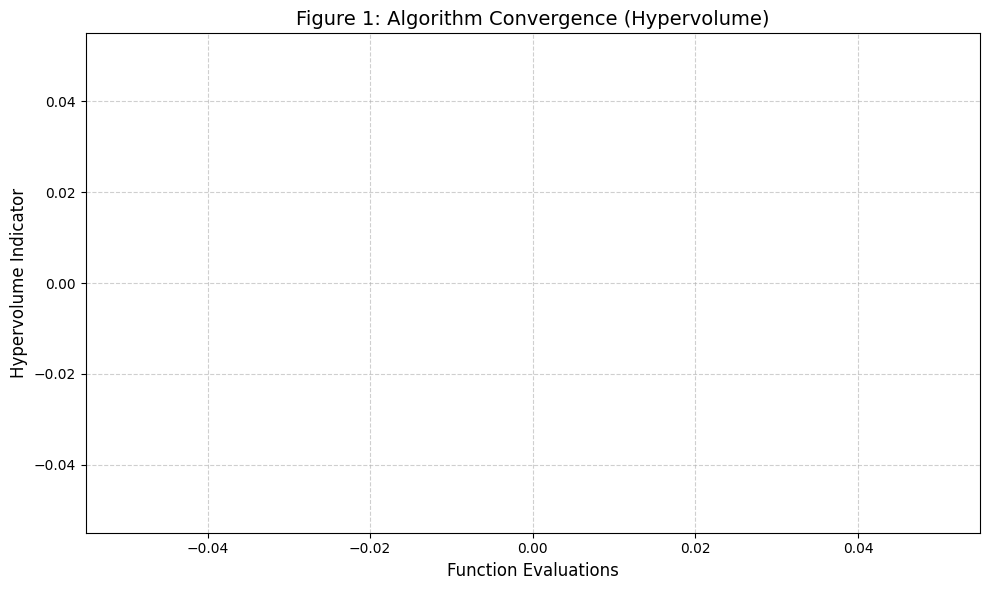

In [ ]:
# @title 5. Figure 1: Convergence Analysis
from pymoo.indicators.hv import HV

# Calculate Hypervolume history
nadir = np.max(res.F, axis=0) * 1.1
hv_metric = HV(ref_point=nadir)
hv_history = [hv_metric(e.pop.get("F")) for e in res.history]
n_evals = [e.evaluator.n_eval for e in res.history]

plt.figure(figsize=(10, 6))
plt.plot(n_evals, hv_history, color='#2c3e50', linewidth=2)
plt.title("Figure 1: Algorithm Convergence (Hypervolume)", fontsize=14)
plt.xlabel("Function Evaluations", fontsize=12)
plt.ylabel("Hypervolume Indicator", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

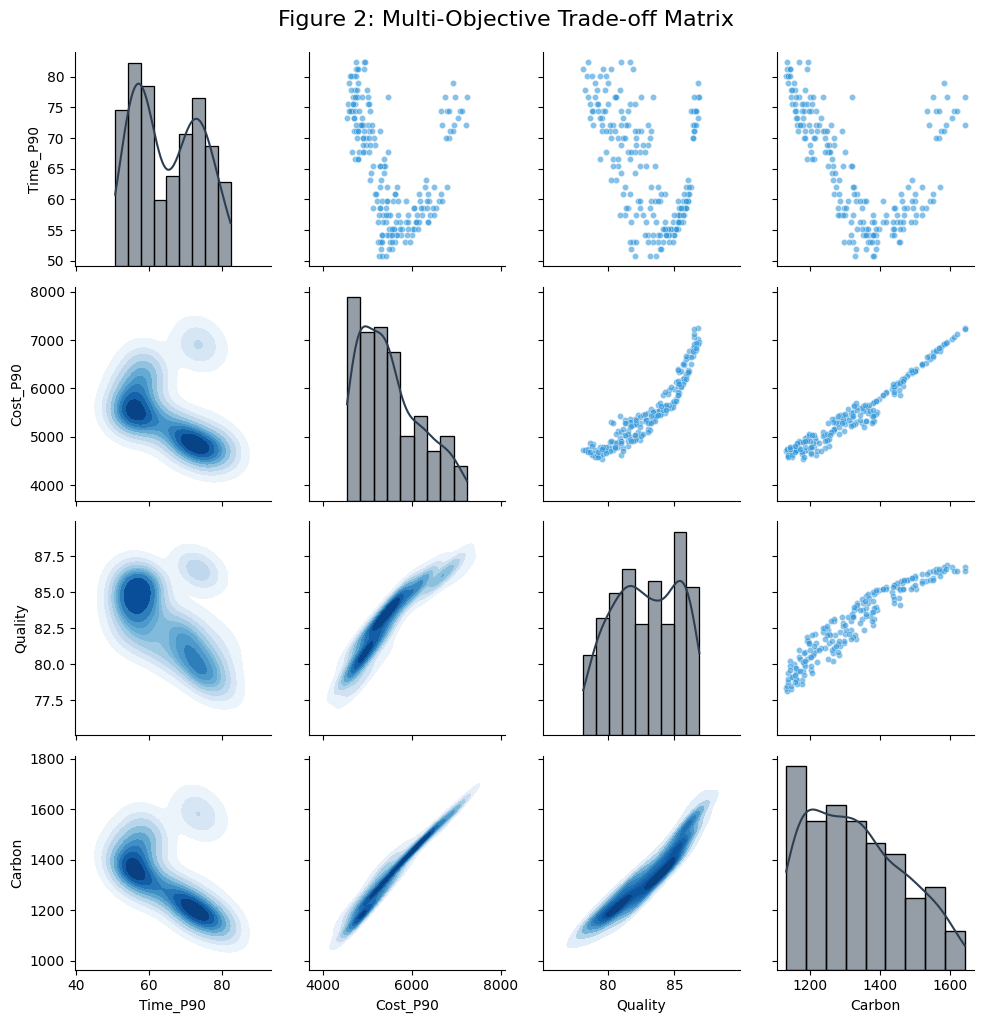

In [ ]:
# @title 6. Figure 2: Pairwise 5D Trade-off Analysis
g = sns.PairGrid(df_res[['Time_P90', 'Cost_P90', 'Quality', 'Carbon']], diag_sharey=False)
g.map_upper(sns.scatterplot, s=20, color='#3498db', alpha=0.6)
g.map_lower(sns.kdeplot, fill=True, cmap='Blues')
g.map_diag(sns.histplot, kde=True, color='#2c3e50')
g.fig.suptitle('Figure 2: Multi-Objective Trade-off Matrix', y=1.02, fontsize=16)
plt.show()

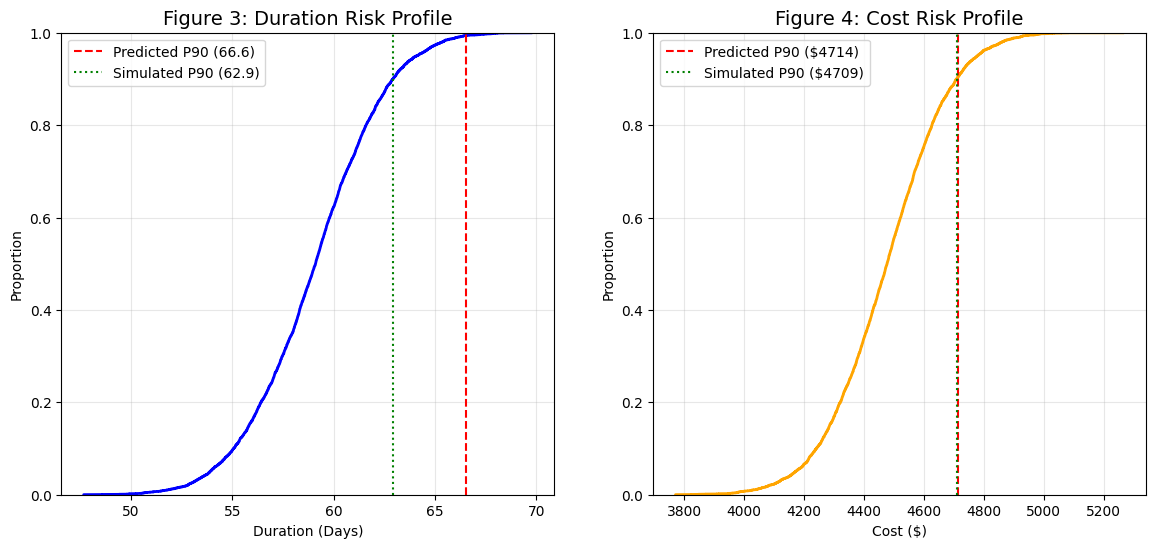

In [ ]:
# @title 7. Figure 3 & 4: Robustness Validation (S-Curves)
def run_monte_carlo(mode_indices, n_sim=5000):
    t_dist = []
    c_dist = []
    for _ in range(n_sim):
        ef = {i: 0 for i in activities_data}
        c_sum = 0
        for i in sorted(activities_data.keys()):
            idx = mode_indices[i-1]
            m = activities_data[i]['modes'][idx]

            # Stochastic Draw
            d = np.random.normal(m['dur'], m['dur_std'])
            c = np.random.normal(m['cost'], m['cost_std'])
            c_sum += c

            preds = activities_data[i]['pred']
            start = max([ef[p] for p in preds]) if preds else 0
            ef[i] = start + d
        t_dist.append(max(ef.values()))
        c_dist.append(c_sum)
    return np.array(t_dist), np.array(c_dist)

mc_t, mc_c = run_monte_carlo(best_modes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Time S-Curve
sns.ecdfplot(mc_t, ax=ax1, color='blue', linewidth=2)
ax1.axvline(best_solution['Time_P90'], color='red', linestyle='--', label=f"Predicted P90 ({best_solution['Time_P90']:.1f})")
ax1.axvline(np.percentile(mc_t, 90), color='green', linestyle=':', label=f"Simulated P90 ({np.percentile(mc_t, 90):.1f})")
ax1.set_title("Figure 3: Duration Risk Profile", fontsize=14)
ax1.set_xlabel("Duration (Days)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cost S-Curve
sns.ecdfplot(mc_c, ax=ax2, color='orange', linewidth=2)
ax2.axvline(best_solution['Cost_P90'], color='red', linestyle='--', label=f"Predicted P90 (${best_solution['Cost_P90']:.0f})")
ax2.axvline(np.percentile(mc_c, 90), color='green', linestyle=':', label=f"Simulated P90 (${np.percentile(mc_c, 90):.0f})")
ax2.set_title("Figure 4: Cost Risk Profile", fontsize=14)
ax2.set_xlabel("Cost ($)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()

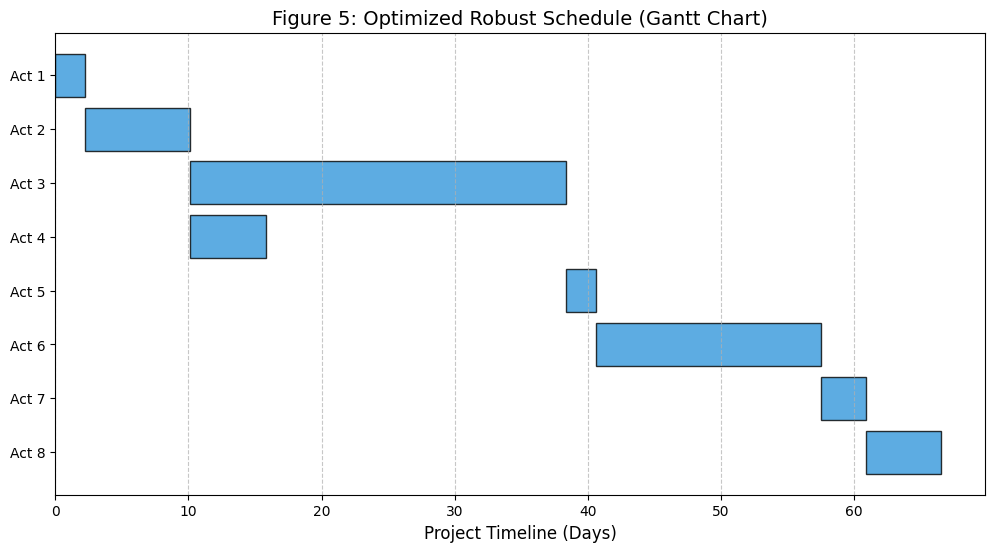

In [ ]:
# @title 8. Figure 5: Gantt Chart (Best Schedule)
# Calculates explicit start/end times for the best P90 schedule
es_final = {}
ef_final = {}
labels = []
starts = []
durations = []

for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    p90_dur = m['dur'] + 1.28*m['dur_std']

    preds = activities_data[i]['pred']
    start = max([ef_final[p] for p in preds]) if preds else 0
    es_final[i] = start
    ef_final[i] = start + p90_dur

    labels.append(f"Act {i}")
    starts.append(start)
    durations.append(p90_dur)

plt.figure(figsize=(12, 6))
plt.barh(labels, durations, left=starts, color='#3498db', edgecolor='black', alpha=0.8)
plt.title("Figure 5: Optimized Robust Schedule (Gantt Chart)", fontsize=14)
plt.xlabel("Project Timeline (Days)", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

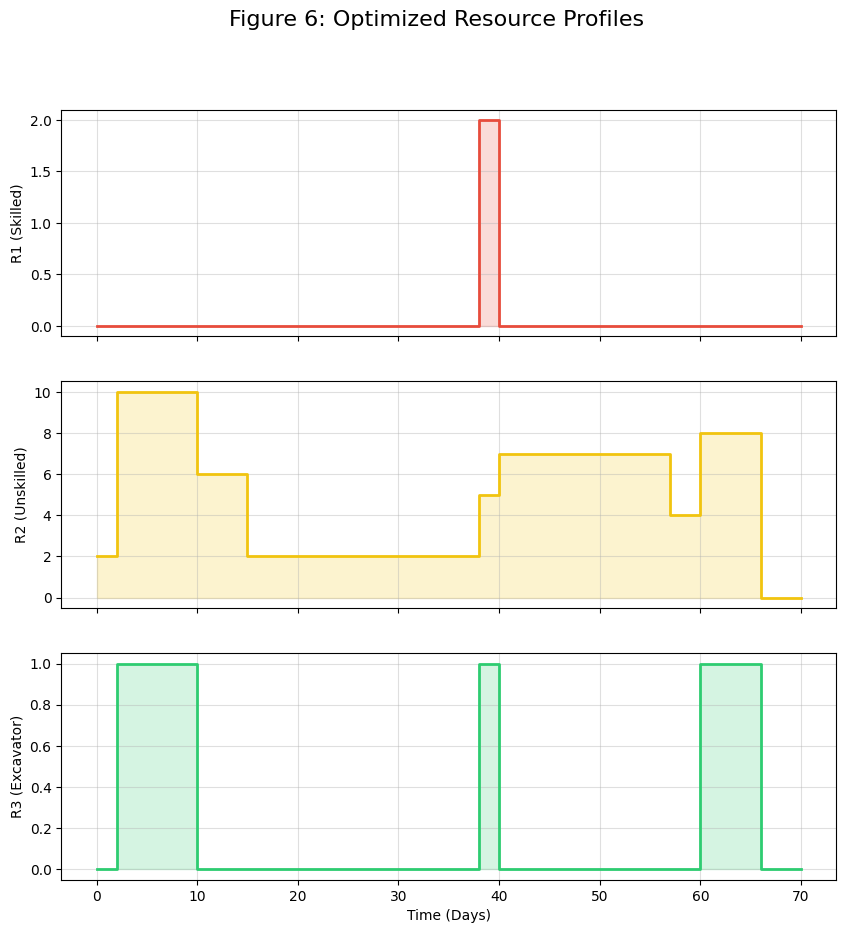

In [ ]:
# @title 9. Figure 6: Resource Profiles (Leveling)
# Recreates the resource usage histograms based on the P90 schedule
horizon = int(max(ef_final.values())) + 5
res_plots = np.zeros((3, horizon))

for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    s = int(es_final[i])
    d = int(ef_final[i]) - s # integer duration for array indexing
    for r in range(3):
        res_plots[r, s:s+d] += m['r'][r]

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
res_names = ['R1 (Skilled)', 'R2 (Unskilled)', 'R3 (Excavator)']
colors = ['#e74c3c', '#f1c40f', '#2ecc71']

for i, ax in enumerate(axes):
    ax.step(range(horizon), res_plots[i], where='post', color=colors[i], linewidth=2)
    ax.fill_between(range(horizon), res_plots[i], step='post', alpha=0.2, color=colors[i])
    ax.set_ylabel(res_names[i])
    ax.grid(True, alpha=0.4)

axes[2].set_xlabel("Time (Days)")
fig.suptitle("Figure 6: Optimized Resource Profiles", fontsize=16)
plt.show()

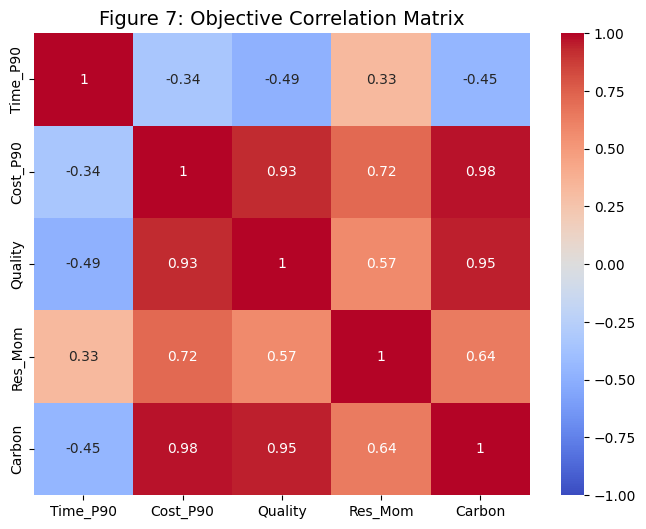

In [ ]:
# @title 10. Figure 7: Objective Correlation Heatmap
# Statistical validation of conflict between objectives
corr = df_res[['Time_P90', 'Cost_P90', 'Quality', 'Res_Mom', 'Carbon']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Figure 7: Objective Correlation Matrix", fontsize=14)
plt.show()

In [ ]:
# @title 11. Generate Manuscript Tables (Excel)

# Table 3: Detailed Schedule of Best Solution
t3_data = []
for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    t3_data.append({
        "Activity": i,
        "Method": idx + 1,
        "Mean Duration": m['dur'],
        "P90 Start": round(es_final[i], 1),
        "P90 Finish": round(ef_final[i], 1),
        "P90 Cost": round(m['cost'] + 1.28*m['cost_std'], 1),
        "Quality": f"{int(m['q']*100)}%",
        "Carbon (kg)": round(m['co2'], 1),
        "R1": m['r'][0], "R2": m['r'][1], "R3": m['r'][2]
    })
df_t3 = pd.DataFrame(t3_data)

# Table 4: Comparison of Extreme Solutions
comp_indices = {
    'Fastest (Time)': df_res['Time_P90'].idxmin(),
    'Cheapest (Cost)': df_res['Cost_P90'].idxmin(),
    'Best Quality': df_res['Quality'].idxmax(),
    'Greenest (Carbon)': df_res['Carbon'].idxmin(),
    'Best Compromise': best_idx
}

t4_data = []
for label, idx in comp_indices.items():
    row = df_res.iloc[idx].to_dict()
    row['Strategy'] = label
    t4_data.append(row)
df_t4 = pd.DataFrame(t4_data)
# Reorder cols
df_t4 = df_t4[['Strategy', 'Time_P90', 'Cost_P90', 'Quality', 'Carbon', 'Res_Mom']]

# Display Tables
print("--- TABLE 3: OPTIMIZED SCHEDULE DETAILS ---")
display(df_t3)
print("\n--- TABLE 4: STRATEGY COMPARISON ---")
display(df_t4)

# Export
with pd.ExcelWriter("Manuscript_Tables_Final.xlsx") as writer:
    df_t3.to_excel(writer, sheet_name="Best_Schedule", index=False)
    df_t4.to_excel(writer, sheet_name="Comparison", index=False)
    df_res.to_excel(writer, sheet_name="All_Solutions", index=False)

print("\nFinal Data successfully exported to 'Manuscript_Tables_Final.xlsx'")

--- TABLE 3: OPTIMIZED SCHEDULE DETAILS ---


,Activity,Method,Mean Duration,P90 Start,P90 Finish,P90 Cost,Quality,Carbon (kg),R1,R2,R3
0,1,1,2,0.0,2.3,1128.0,80%,275.0,0,2,0
1,2,4,7,2.3,10.2,1152.8,82%,225.8,0,10,1
2,3,1,25,10.2,38.4,451.2,74%,86.0,0,2,0
3,4,1,5,10.2,15.8,180.5,77%,62.0,0,4,0
4,5,4,2,38.4,40.6,347.4,85%,136.6,2,5,1
5,6,4,15,40.6,57.5,947.5,82%,178.0,0,7,0
6,7,7,3,57.5,60.9,108.3,87%,69.2,0,4,0
7,8,4,5,60.9,66.6,733.2,76%,160.0,0,8,1



--- TABLE 4: STRATEGY COMPARISON ---


,Strategy,Time_P90,Cost_P90,Quality,Carbon,Res_Mom
0,Fastest (Time),50.760,5266.906641,82.000,1329.728571,11232.0
1,Cheapest (Cost),73.320,4538.654437,79.500,1180.846753,12187.0
2,Best Quality,76.704,6958.849460,86.875,1591.032552,25597.0
3,Greenest (Carbon),80.088,4695.653123,78.375,1133.075325,13119.0
4,Best Compromise,66.552,4714.171647,80.375,1192.628571,12638.0



Final Data successfully exported to 'Manuscript_Tables_Final.xlsx'


In [ ]:
# @title 1. Installation & Setup
!pip install pymoo pandas numpy matplotlib seaborn scipy openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.termination import get_termination
from pymoo.indicators.hv import HV
from pandas.plotting import parallel_coordinates
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [ ]:
# @title 2. Data Engineering: Stochastic & Carbon Parameters
# Logic: We extend the case study to include Risk (StdDev) and Sustainability (Carbon)

activities_data = {
    1: {'pred': [], 'modes': [{'id': 1, 'dur': 2, 'cost': 1000, 'q': 0.80, 'r': [0, 2, 0]}]},
    2: {'pred': [1], 'modes': [
        {'id': 1, 'dur': 14, 'cost': 1260, 'q': 0.78, 'r': [0, 3, 1]},
        {'id': 2, 'dur': 10, 'cost': 1220, 'q': 0.80, 'r': [0, 7, 1]},
        {'id': 3, 'dur': 8, 'cost': 1376, 'q': 0.83, 'r': [0, 5, 2]},
        {'id': 4, 'dur': 7, 'cost': 1022, 'q': 0.82, 'r': [0, 10, 1]},
        {'id': 5, 'dur': 12, 'cost': 1464, 'q': 0.84, 'r': [0, 7, 1]},
        {'id': 6, 'dur': 10, 'cost': 1720, 'q': 0.87, 'r': [0, 5, 2]},
        {'id': 7, 'dur': 10, 'cost': 1460, 'q': 0.88, 'r': [0, 10, 1]}
    ]},
    3: {'pred': [2], 'modes': [
        {'id': 1, 'dur': 25, 'cost': 400, 'q': 0.74, 'r': [0, 2, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 16, 'cost': 896, 'q': 0.83, 'r': [0, 7, 0]},
        {'id': 4, 'dur': 12, 'cost': 960, 'q': 0.90, 'r': [0, 10, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 18, 'cost': 1008, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 7, 'dur': 14, 'cost': 1120, 'q': 0.92, 'r': [0, 10, 0]}
    ]},
    4: {'pred': [1, 2], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 160, 'q': 0.77, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 4, 'cost': 224, 'q': 0.80, 'r': [0, 7, 0]},
        {'id': 3, 'dur': 3, 'cost': 240, 'q': 0.83, 'r': [0, 10, 0]},
        {'id': 4, 'dur': 2, 'cost': 208, 'q': 0.86, 'r': [0, 13, 0]},
        {'id': 5, 'dur': 5, 'cost': 280, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 6, 'dur': 4, 'cost': 320, 'q': 0.88, 'r': [0, 10, 0]},
        {'id': 7, 'dur': 3, 'cost': 312, 'q': 0.90, 'r': [0, 13, 0]}
    ]},
    5: {'pred': [3], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 570, 'q': 0.76, 'r': [1, 3, 1]},
        {'id': 2, 'dur': 3, 'cost': 414, 'q': 0.80, 'r': [2, 3, 1]},
        {'id': 3, 'dur': 4, 'cost': 488, 'q': 0.75, 'r': [1, 4, 1]},
        {'id': 4, 'dur': 2, 'cost': 308, 'q': 0.85, 'r': [2, 5, 1]},
        {'id': 5, 'dur': 4, 'cost': 552, 'q': 0.86, 'r': [2, 3, 1]},
        {'id': 6, 'dur': 5, 'cost': 610, 'q': 0.82, 'r': [1, 4, 1]},
        {'id': 7, 'dur': 3, 'cost': 462, 'q': 0.92, 'r': [2, 5, 1]}
    ]},
    6: {'pred': [4, 5], 'modes': [
        {'id': 1, 'dur': 22, 'cost': 704, 'q': 0.78, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 17, 'cost': 816, 'q': 0.81, 'r': [0, 6, 0]},
        {'id': 4, 'dur': 15, 'cost': 840, 'q': 0.82, 'r': [0, 7, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 19, 'cost': 912, 'q': 0.83, 'r': [0, 6, 0]},
        {'id': 7, 'dur': 17, 'cost': 952, 'q': 0.84, 'r': [0, 7, 0]}
    ]},
    7: {'pred': [6], 'modes': [
        {'id': 1, 'dur': 11, 'cost': 880, 'q': 0.82, 'r': [0, 1, 0]},
        {'id': 2, 'dur': 7, 'cost': 112, 'q': 0.80, 'r': [0, 2, 0]},
        {'id': 3, 'dur': 4, 'cost': 96, 'q': 0.81, 'r': [0, 3, 0]},
        {'id': 4, 'dur': 2, 'cost': 64, 'q': 0.84, 'r': [0, 4, 0]},
        {'id': 5, 'dur': 8, 'cost': 128, 'q': 0.83, 'r': [0, 2, 0]},
        {'id': 6, 'dur': 5, 'cost': 120, 'q': 0.83, 'r': [0, 3, 0]},
        {'id': 7, 'dur': 3, 'cost': 96, 'q': 0.87, 'r': [0, 4, 0]}
    ]},
    8: {'pred': [7], 'modes': [
        {'id': 1, 'dur': 19, 'cost': 1216, 'q': 0.82, 'r': [0, 8, 0]},
        {'id': 2, 'dur': 15, 'cost': 1200, 'q': 0.80, 'r': [0, 10, 0]},
        {'id': 3, 'dur': 6, 'cost': 684, 'q': 0.74, 'r': [0, 6, 1]},
        {'id': 4, 'dur': 5, 'cost': 650, 'q': 0.76, 'r': [0, 8, 1]},
        {'id': 5, 'dur': 16, 'cost': 1280, 'q': 0.81, 'r': [0, 10, 0]},
        {'id': 6, 'dur': 7, 'cost': 798, 'q': 0.75, 'r': [0, 6, 1]},
        {'id': 7, 'dur': 6, 'cost': 780, 'q': 0.77, 'r': [0, 8, 1]}
    ]}
}

# Add synthetic stochastic data
np.random.seed(42)
for act in activities_data.values():
    for m in act['modes']:
        # Carbon: Correlated with Cost (Materials) + Inverse Duration (Machine Intensity)
        m['co2'] = (0.2 * m['cost']) + (150 / m['dur'])
        # Risk: 10% Standard Deviation used for P90 estimation
        m['dur_std'] = m['dur'] * 0.10
        m['cost_std'] = m['cost'] * 0.10

print("Data initialized correctly.")

Data initialized correctly.


In [ ]:
# @title 3. Optimization Engine (NSGA-II for Robust 5D Problem)

class Robust5DConstruction(ElementwiseProblem):
    def __init__(self):
        xl = np.zeros(8)
        xu = np.array([len(activities_data[i]['modes'])-1 for i in range(1, 9)])
        # Objectives: [P90 Duration, P90 Cost, -Quality, ResourceMom, Carbon]
        super().__init__(n_var=8, n_obj=5, n_ieq_constr=0, xl=xl, xu=xu, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        indices = x.astype(int)
        Z = 1.28 # P90 Z-score

        es_p90 = {i: 0 for i in activities_data}
        ef_p90 = {i: 0 for i in activities_data}

        cost_mean = 0
        cost_var = 0
        total_qual = 0
        total_co2 = 0

        # Resource Profile (Buffer 300 days)
        res_profile = np.zeros((3, 300))
        max_finish = 0

        for i in sorted(activities_data.keys()):
            idx = indices[i-1]
            m = activities_data[i]['modes'][idx]

            # Robust Time (PERT Logic)
            p90_dur = m['dur'] + Z * m['dur_std']
            preds = activities_data[i]['pred']
            start = max([ef_p90[p] for p in preds]) if preds else 0

            es_p90[i] = start
            ef_p90[i] = start + p90_dur

            # Robust Cost
            cost_mean += m['cost']
            cost_var += m['cost_std']**2

            # Quality & Carbon
            total_qual += m['q']
            total_co2 += m['co2']

            # Resource Leveling (On P90 timeline to be conservative)
            s_idx = int(start)
            d_idx = int(p90_dur)
            for r in range(3):
                res_profile[r, s_idx:s_idx+d_idx] += m['r'][r]

            max_finish = max(max_finish, s_idx + d_idx)

        # Metrics
        f1_time = max(ef_p90.values())
        f2_cost = cost_mean + Z * np.sqrt(cost_var)
        f3_qual = - (total_qual / 8) * 100
        f5_co2 = total_co2

        # Resource Moment
        m_tot = 0
        for r in range(3):
            usage = res_profile[r, :max_finish+1]
            mx = 0.5 * np.sum(usage**2)
            my = np.sum(usage * (np.arange(1, len(usage)+1) - 0.5))
            m_tot += (mx + my)

        out["F"] = [f1_time, f2_cost, f3_qual, m_tot, f5_co2]

# --- Run NSGA-II ---
problem = Robust5DConstruction()
algorithm = NSGA2(
    pop_size=200,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=0.1, eta=20, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)

print("Starting Robust 5D Optimization...")
res = minimize(problem, algorithm, get_termination("n_gen", 500), seed=1, verbose=True)
print(f"Done. Found {len(res.F)} non-dominated solutions.")

Starting Robust 5D Optimization...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     26 |             - |             -
     2 |      400 |     49 |  0.1090909091 |         ideal
     3 |      600 |     58 |  0.1034482759 |         ideal
     4 |      800 |     75 |  0.0508474576 |         ideal
     5 |     1000 |     89 |  0.0689655172 |         ideal
     6 |     1200 |    109 |  0.0740740741 |         ideal
     7 |     1400 |    129 |  0.0392418609 |         ideal
     8 |     1600 |    170 |  0.0588235294 |         ideal
     9 |     1800 |    200 |  0.0122356602 |         ideal
    10 |     2000 |    200 |  0.0131894969 |         ideal
    11 |     2200 |    200 |  0.0035598745 |         ideal
    12 |     2400 |    200 |  0.0039398325 |         ideal
    13 |     2600 |    200 |  0.0035333206 |         ideal
    14 |     2800 |    200 |  0.0123388569 |             f
    15 |     3000 |    200 |  0.0157711957 |             f
    16 |     3200 |  

In [ ]:
# @title 4. Multi-Criteria Decision Making (TOPSIS)

# Create DataFrame
df_res = pd.DataFrame(res.F, columns=['Time_P90', 'Cost_P90', 'Quality_Neg', 'Res_Mom', 'Carbon'])
df_res['Quality'] = -df_res['Quality_Neg']
df_res = df_res.drop('Quality_Neg', axis=1)

# Weights (Expert Input: Sustainable Balance)
weights = np.array([0.20, 0.25, 0.15, 0.15, 0.25])

# Normalize
norm_df = df_res / np.sqrt((df_res**2).sum())
weighted = norm_df * weights

# Ideals
best_ideal = [weighted['Time_P90'].min(), weighted['Cost_P90'].min(), weighted['Quality'].max(), weighted['Res_Mom'].min(), weighted['Carbon'].min()]
worst_ideal = [weighted['Time_P90'].max(), weighted['Cost_P90'].max(), weighted['Quality'].min(), weighted['Res_Mom'].max(), weighted['Carbon'].max()]

# Distances
s_plus = np.sqrt(((weighted - best_ideal)**2).sum(axis=1))
s_minus = np.sqrt(((weighted - worst_ideal)**2).sum(axis=1))

# Score
df_res['Score'] = s_minus / (s_plus + s_minus)
best_idx = df_res['Score'].idxmax()
best_solution = df_res.iloc[best_idx]
best_modes = res.X[best_idx].astype(int)

print("--- SELECTED BEST COMPROMISE SOLUTION ---")
print(best_solution)

--- SELECTED BEST COMPROMISE SOLUTION ---
Time_P90       66.552000
Cost_P90     4714.171647
Res_Mom     12638.000000
Carbon       1192.628571
Quality        80.375000
Score           0.547054
Name: 83, dtype: float64


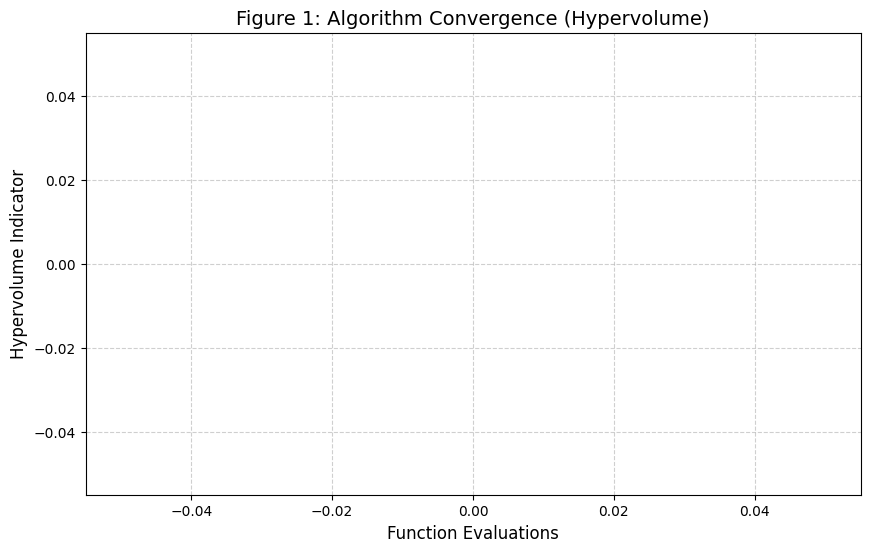

In [ ]:
# @title 5. Figure 1: Convergence Analysis
nadir = np.max(res.F, axis=0) * 1.1
hv = [HV(ref_point=nadir)(e.pop.get("F")) for e in res.history]
n_evals = [e.evaluator.n_eval for e in res.history]

plt.figure(figsize=(10, 6))
plt.plot(n_evals, hv, color='#2c3e50', linewidth=2)
plt.title("Figure 1: Algorithm Convergence (Hypervolume)", fontsize=14)
plt.xlabel("Function Evaluations", fontsize=12)
plt.ylabel("Hypervolume Indicator", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

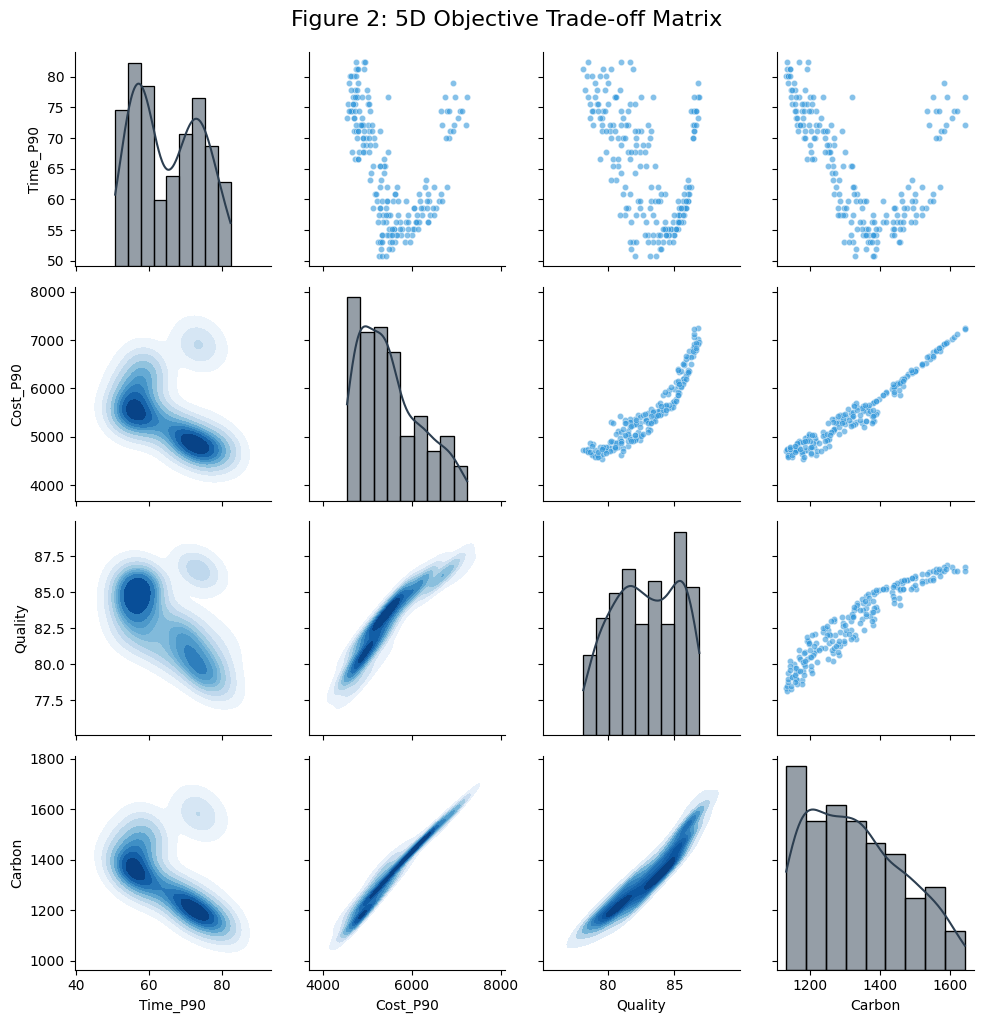

In [ ]:
# @title 6. Figure 2: Pairwise Trade-off Analysis
g = sns.PairGrid(df_res[['Time_P90', 'Cost_P90', 'Quality', 'Carbon']], diag_sharey=False)
g.map_upper(sns.scatterplot, s=20, color='#3498db', alpha=0.6)
g.map_lower(sns.kdeplot, fill=True, cmap='Blues')
g.map_diag(sns.histplot, kde=True, color='#2c3e50')
g.fig.suptitle('Figure 2: 5D Objective Trade-off Matrix', y=1.02, fontsize=16)
plt.show()

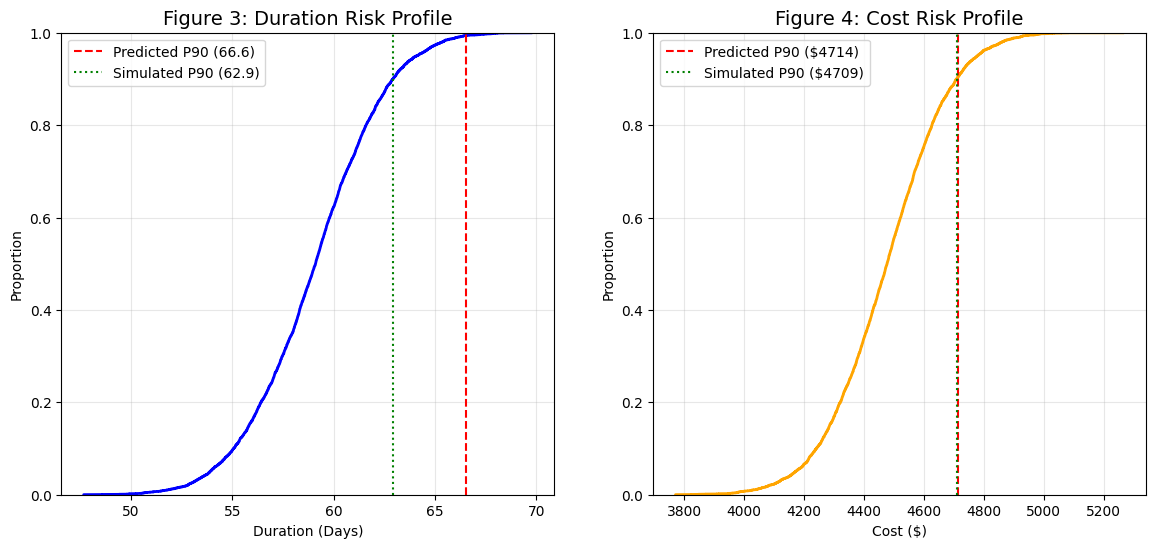

In [ ]:
# @title 7. Figure 3 & 4: Robustness Verification (Monte Carlo)
def run_monte_carlo(mode_indices, n_sim=5000):
    t_dist = []
    c_dist = []
    for _ in range(n_sim):
        ef = {i: 0 for i in activities_data}
        c_sum = 0
        for i in sorted(activities_data.keys()):
            idx = mode_indices[i-1]
            m = activities_data[i]['modes'][idx]
            d = np.random.normal(m['dur'], m['dur_std'])
            c = np.random.normal(m['cost'], m['cost_std'])
            c_sum += c
            preds = activities_data[i]['pred']
            start = max([ef[p] for p in preds]) if preds else 0
            ef[i] = start + d
        t_dist.append(max(ef.values()))
        c_dist.append(c_sum)
    return np.array(t_dist), np.array(c_dist)

mc_t, mc_c = run_monte_carlo(best_modes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.ecdfplot(mc_t, ax=ax1, color='blue', linewidth=2)
ax1.axvline(best_solution['Time_P90'], color='red', linestyle='--', label=f"Predicted P90 ({best_solution['Time_P90']:.1f})")
ax1.axvline(np.percentile(mc_t, 90), color='green', linestyle=':', label=f"Simulated P90 ({np.percentile(mc_t, 90):.1f})")
ax1.set_title("Figure 3: Duration Risk Profile", fontsize=14)
ax1.set_xlabel("Duration (Days)")
ax1.legend()
ax1.grid(True, alpha=0.3)

sns.ecdfplot(mc_c, ax=ax2, color='orange', linewidth=2)
ax2.axvline(best_solution['Cost_P90'], color='red', linestyle='--', label=f"Predicted P90 (${best_solution['Cost_P90']:.0f})")
ax2.axvline(np.percentile(mc_c, 90), color='green', linestyle=':', label=f"Simulated P90 (${np.percentile(mc_c, 90):.0f})")
ax2.set_title("Figure 4: Cost Risk Profile", fontsize=14)
ax2.set_xlabel("Cost ($)")
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.show()

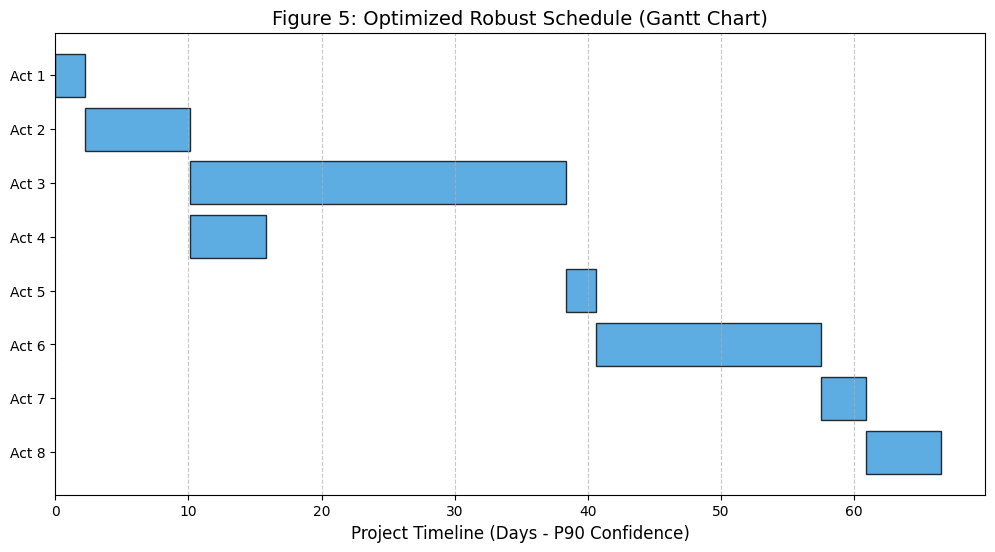

In [ ]:
# @title 8. Figure 5: Gantt Chart (Optimized Schedule)
# Calculate exact P90 schedule
es_final = {}
ef_final = {}
labels = []
starts = []
durs_p90 = []

for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    p90_d = m['dur'] + 1.28*m['dur_std']
    preds = activities_data[i]['pred']
    s = max([ef_final[p] for p in preds]) if preds else 0

    es_final[i] = s
    ef_final[i] = s + p90_d

    labels.append(f"Act {i}")
    starts.append(s)
    durs_p90.append(p90_d)

plt.figure(figsize=(12, 6))
plt.barh(labels, durs_p90, left=starts, color='#3498db', edgecolor='black', alpha=0.8)
plt.title("Figure 5: Optimized Robust Schedule (Gantt Chart)", fontsize=14)
plt.xlabel("Project Timeline (Days - P90 Confidence)", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

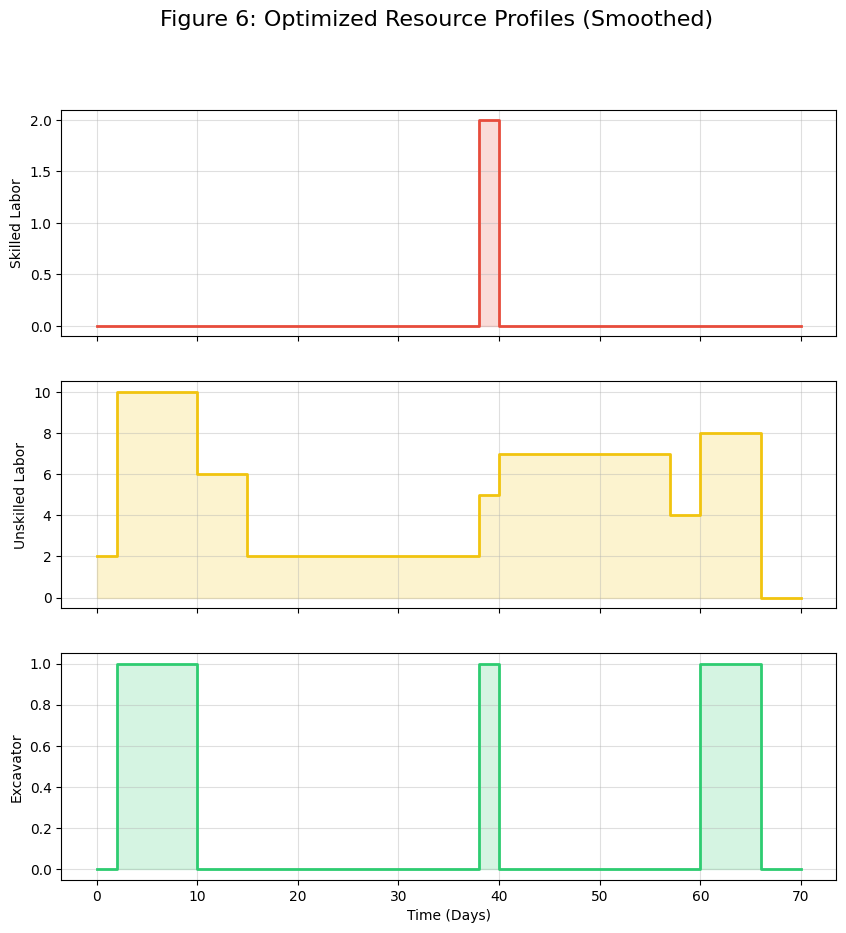

In [ ]:
# @title 9. Figure 6: Resource Profiles
# Based on P90 duration to ensure consistency
horizon = int(max(ef_final.values())) + 5
res_plots = np.zeros((3, horizon))

for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    s = int(es_final[i])
    d = int(ef_final[i]) - s
    if d < 1: d = 1 # min duration 1
    for r in range(3):
        res_plots[r, s:s+d] += m['r'][r]

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
res_names = ['Skilled Labor', 'Unskilled Labor', 'Excavator']
colors = ['#e74c3c', '#f1c40f', '#2ecc71']

for i, ax in enumerate(axes):
    ax.step(range(horizon), res_plots[i], where='post', color=colors[i], linewidth=2)
    ax.fill_between(range(horizon), res_plots[i], step='post', alpha=0.2, color=colors[i])
    ax.set_ylabel(res_names[i])
    ax.grid(True, alpha=0.4)

axes[2].set_xlabel("Time (Days)")
fig.suptitle("Figure 6: Optimized Resource Profiles (Smoothed)", fontsize=16)
plt.show()

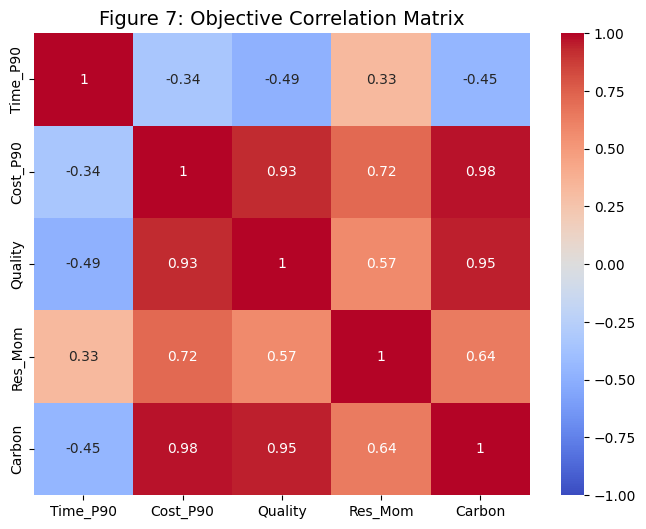

In [ ]:
# @title 10. Figure 7: Objective Correlation Matrix
corr = df_res[['Time_P90', 'Cost_P90', 'Quality', 'Res_Mom', 'Carbon']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Figure 7: Objective Correlation Matrix", fontsize=14)
plt.show()

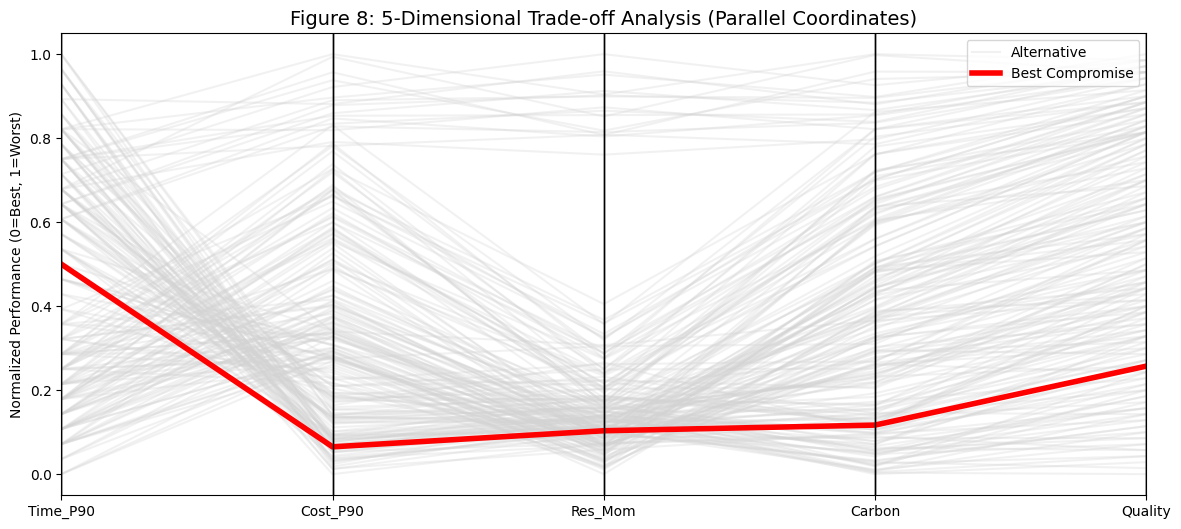

In [ ]:
# @title 11. Figure 8: Parallel Coordinates (High-Dim Trade-offs)
# Prepare data: normalize 0-1
pc_df = df_res.drop('Score', axis=1).copy()
pc_df = (pc_df - pc_df.min()) / (pc_df.max() - pc_df.min())
pc_df['Type'] = 'Alternative'
pc_df.loc[best_idx, 'Type'] = 'Best Compromise'

plt.figure(figsize=(14, 6))
parallel_coordinates(pc_df[pc_df['Type']=='Alternative'], 'Type', color='lightgrey', alpha=0.3)
parallel_coordinates(pc_df[pc_df['Type']=='Best Compromise'], 'Type', color='red', linewidth=4)
plt.title("Figure 8: 5-Dimensional Trade-off Analysis (Parallel Coordinates)", fontsize=14)
plt.ylabel("Normalized Performance (0=Best, 1=Worst)")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# @title 12. Final Tables Export (Tables 3 & 4)
# Table 3: Detailed Schedule
t3_data = []
for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    t3_data.append({
        "Activity": i, "Method": idx + 1,
        "P90 Duration": round(m['dur'] + 1.28*m['dur_std'], 1),
        "Start": round(es_final[i], 1), "Finish": round(ef_final[i], 1),
        "Cost ($)": m['cost'], "Risk Buffer ($)": round(1.28*m['cost_std'], 1),
        "Quality": f"{int(m['q']*100)}%", "Carbon": round(m['co2'], 1)
    })
df_t3 = pd.DataFrame(t3_data)

# Table 4: Extreme Solutions
indices = {
    'Fastest (Min Time)': df_res['Time_P90'].idxmin(),
    'Cheapest (Min Cost)': df_res['Cost_P90'].idxmin(),
    'Best Quality': df_res['Quality'].idxmax(),
    'Greenest (Min Carbon)': df_res['Carbon'].idxmin(),
    'Best Compromise': best_idx
}
t4_data = []
for k, v in indices.items():
    row = df_res.iloc[v].to_dict()
    row['Strategy'] = k
    t4_data.append(row)
df_t4 = pd.DataFrame(t4_data)[['Strategy', 'Time_P90', 'Cost_P90', 'Quality', 'Carbon', 'Res_Mom']]

print("--- TABLE 3: OPTIMIZED SCHEDULE ---")
display(df_t3)
print("\n--- TABLE 4: COMPARISON OF STRATEGIES ---")
display(df_t4)

with pd.ExcelWriter("Manuscript_Final_Tables.xlsx") as writer:
    df_t3.to_excel(writer, sheet_name="Table3_Schedule", index=False)
    df_t4.to_excel(writer, sheet_name="Table4_Comparison", index=False)

--- TABLE 3: OPTIMIZED SCHEDULE ---


,Activity,Method,P90 Duration,Start,Finish,Cost ($),Risk Buffer ($),Quality,Carbon
0,1,1,2.3,0.0,2.3,1000,128.0,80%,275.0
1,2,4,7.9,2.3,10.2,1022,130.8,82%,225.8
2,3,1,28.2,10.2,38.4,400,51.2,74%,86.0
3,4,1,5.6,10.2,15.8,160,20.5,77%,62.0
4,5,4,2.3,38.4,40.6,308,39.4,85%,136.6
5,6,4,16.9,40.6,57.5,840,107.5,82%,178.0
6,7,7,3.4,57.5,60.9,96,12.3,87%,69.2
7,8,4,5.6,60.9,66.6,650,83.2,76%,160.0



--- TABLE 4: COMPARISON OF STRATEGIES ---


,Strategy,Time_P90,Cost_P90,Quality,Carbon,Res_Mom
0,Fastest (Min Time),50.760,5266.906641,82.000,1329.728571,11232.0
1,Cheapest (Min Cost),73.320,4538.654437,79.500,1180.846753,12187.0
2,Best Quality,76.704,6958.849460,86.875,1591.032552,25597.0
3,Greenest (Min Carbon),80.088,4695.653123,78.375,1133.075325,13119.0
4,Best Compromise,66.552,4714.171647,80.375,1192.628571,12638.0


--- INITIALIZING ROBUST 5D OPTIMIZATION MODEL ---
Running NSGA-II (500 Generations)...
Optimization Complete.
Best Compromise Found: Time=71.1, Cost=$6859


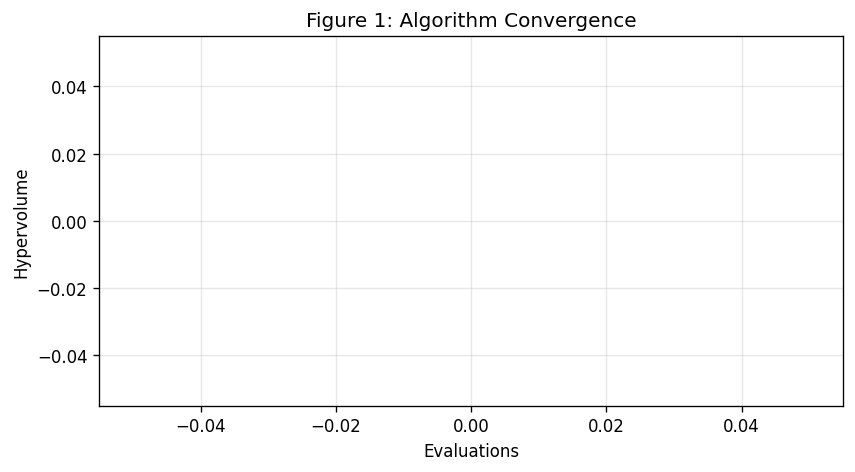

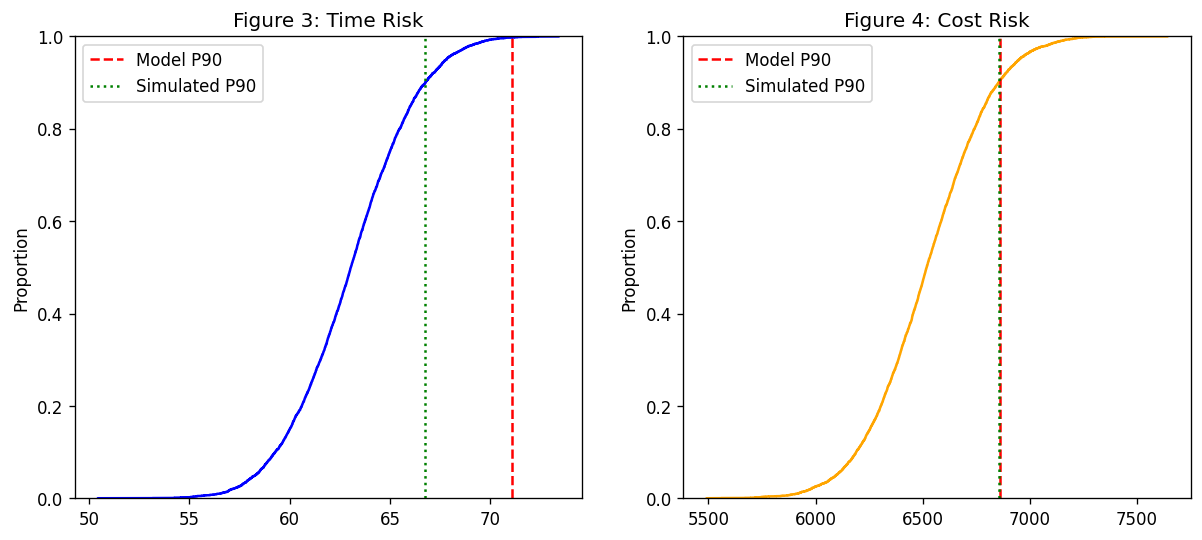

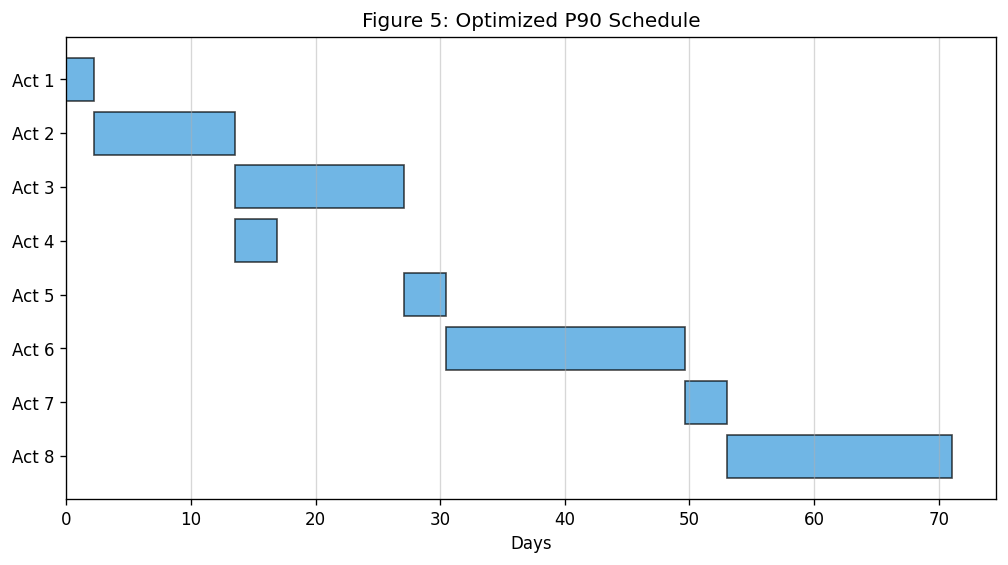

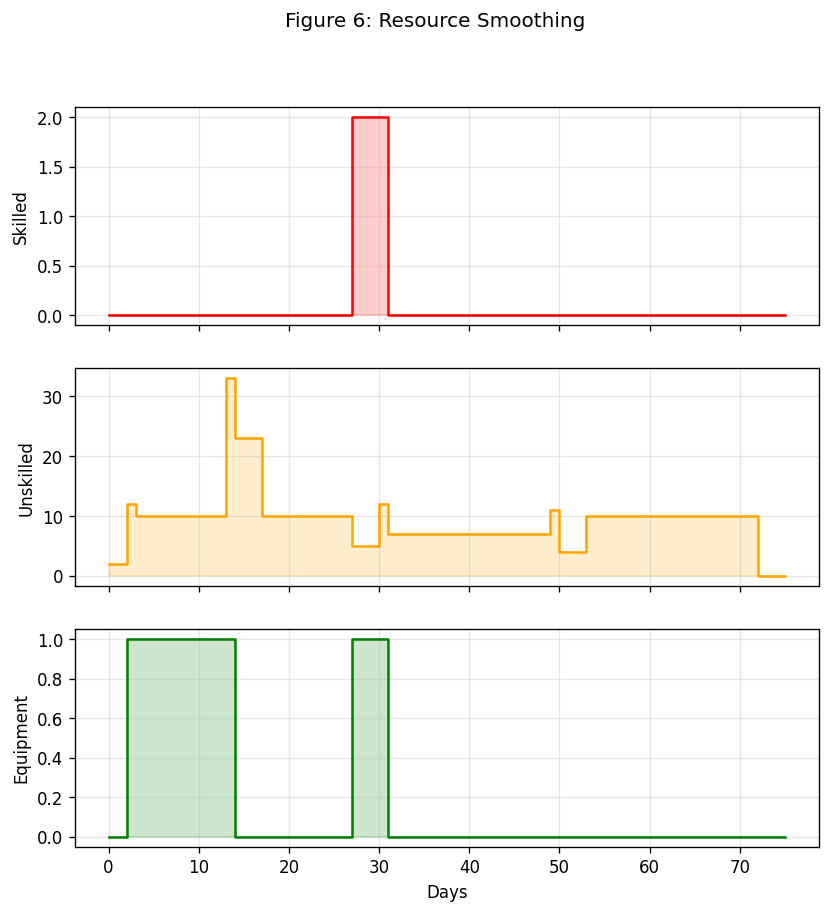

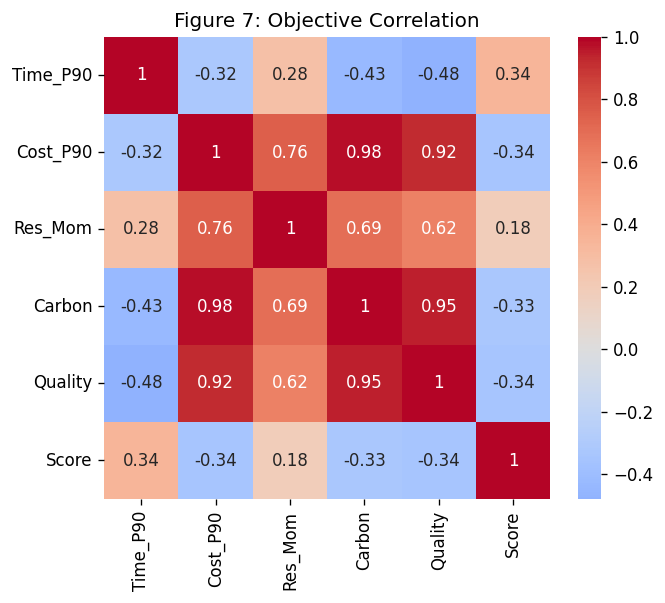

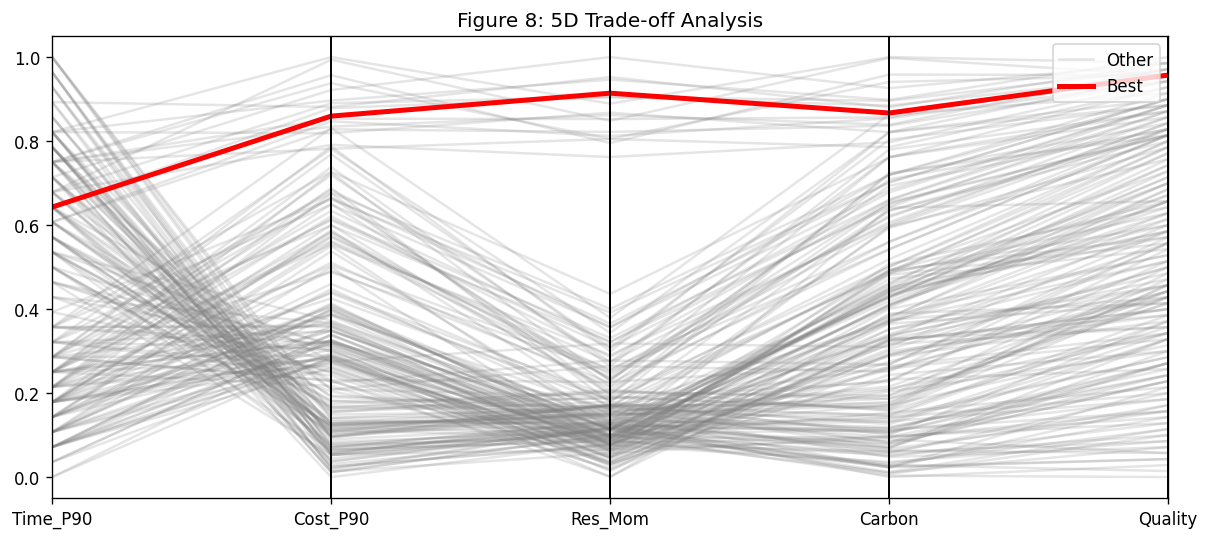

Detailed Schedule saved to 'Final_Results.xlsx'


In [ ]:
# @title 1. Full Framework Execution (Run This Cell)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.termination import get_termination
from pymoo.indicators.hv import HV
from pandas.plotting import parallel_coordinates
import warnings

# Settings for Publication-Quality Figures
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300
warnings.filterwarnings('ignore')

print("--- INITIALIZING ROBUST 5D OPTIMIZATION MODEL ---")

# ==========================================
# PART 1: DATA ENGINEERING
# ==========================================
# Activities with Duration, Cost, Quality, Resources
# Added: 'co2' (Carbon) and 'std' (Risk Variance)
activities_data = {
    1: {'pred': [], 'modes': [{'id': 1, 'dur': 2, 'cost': 1000, 'q': 0.80, 'r': [0, 2, 0]}]},
    2: {'pred': [1], 'modes': [
        {'id': 1, 'dur': 14, 'cost': 1260, 'q': 0.78, 'r': [0, 3, 1]},
        {'id': 2, 'dur': 10, 'cost': 1220, 'q': 0.80, 'r': [0, 7, 1]},
        {'id': 3, 'dur': 8, 'cost': 1376, 'q': 0.83, 'r': [0, 5, 2]},
        {'id': 4, 'dur': 7, 'cost': 1022, 'q': 0.82, 'r': [0, 10, 1]},
        {'id': 5, 'dur': 12, 'cost': 1464, 'q': 0.84, 'r': [0, 7, 1]},
        {'id': 6, 'dur': 10, 'cost': 1720, 'q': 0.87, 'r': [0, 5, 2]},
        {'id': 7, 'dur': 10, 'cost': 1460, 'q': 0.88, 'r': [0, 10, 1]}
    ]},
    3: {'pred': [2], 'modes': [
        {'id': 1, 'dur': 25, 'cost': 400, 'q': 0.74, 'r': [0, 2, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 16, 'cost': 896, 'q': 0.83, 'r': [0, 7, 0]},
        {'id': 4, 'dur': 12, 'cost': 960, 'q': 0.90, 'r': [0, 10, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 18, 'cost': 1008, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 7, 'dur': 14, 'cost': 1120, 'q': 0.92, 'r': [0, 10, 0]}
    ]},
    4: {'pred': [1, 2], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 160, 'q': 0.77, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 4, 'cost': 224, 'q': 0.80, 'r': [0, 7, 0]},
        {'id': 3, 'dur': 3, 'cost': 240, 'q': 0.83, 'r': [0, 10, 0]},
        {'id': 4, 'dur': 2, 'cost': 208, 'q': 0.86, 'r': [0, 13, 0]},
        {'id': 5, 'dur': 5, 'cost': 280, 'q': 0.85, 'r': [0, 7, 0]},
        {'id': 6, 'dur': 4, 'cost': 320, 'q': 0.88, 'r': [0, 10, 0]},
        {'id': 7, 'dur': 3, 'cost': 312, 'q': 0.90, 'r': [0, 13, 0]}
    ]},
    5: {'pred': [3], 'modes': [
        {'id': 1, 'dur': 5, 'cost': 570, 'q': 0.76, 'r': [1, 3, 1]},
        {'id': 2, 'dur': 3, 'cost': 414, 'q': 0.80, 'r': [2, 3, 1]},
        {'id': 3, 'dur': 4, 'cost': 488, 'q': 0.75, 'r': [1, 4, 1]},
        {'id': 4, 'dur': 2, 'cost': 308, 'q': 0.85, 'r': [2, 5, 1]},
        {'id': 5, 'dur': 4, 'cost': 552, 'q': 0.86, 'r': [2, 3, 1]},
        {'id': 6, 'dur': 5, 'cost': 610, 'q': 0.82, 'r': [1, 4, 1]},
        {'id': 7, 'dur': 3, 'cost': 462, 'q': 0.92, 'r': [2, 5, 1]}
    ]},
    6: {'pred': [4, 5], 'modes': [
        {'id': 1, 'dur': 22, 'cost': 704, 'q': 0.78, 'r': [0, 4, 0]},
        {'id': 2, 'dur': 20, 'cost': 800, 'q': 0.80, 'r': [0, 5, 0]},
        {'id': 3, 'dur': 17, 'cost': 816, 'q': 0.81, 'r': [0, 6, 0]},
        {'id': 4, 'dur': 15, 'cost': 840, 'q': 0.82, 'r': [0, 7, 0]},
        {'id': 5, 'dur': 22, 'cost': 880, 'q': 0.82, 'r': [0, 5, 0]},
        {'id': 6, 'dur': 19, 'cost': 912, 'q': 0.83, 'r': [0, 6, 0]},
        {'id': 7, 'dur': 17, 'cost': 952, 'q': 0.84, 'r': [0, 7, 0]}
    ]},
    7: {'pred': [6], 'modes': [
        {'id': 1, 'dur': 11, 'cost': 880, 'q': 0.82, 'r': [0, 1, 0]},
        {'id': 2, 'dur': 7, 'cost': 112, 'q': 0.80, 'r': [0, 2, 0]},
        {'id': 3, 'dur': 4, 'cost': 96, 'q': 0.81, 'r': [0, 3, 0]},
        {'id': 4, 'dur': 2, 'cost': 64, 'q': 0.84, 'r': [0, 4, 0]},
        {'id': 5, 'dur': 8, 'cost': 128, 'q': 0.83, 'r': [0, 2, 0]},
        {'id': 6, 'dur': 5, 'cost': 120, 'q': 0.83, 'r': [0, 3, 0]},
        {'id': 7, 'dur': 3, 'cost': 96, 'q': 0.87, 'r': [0, 4, 0]}
    ]},
    8: {'pred': [7], 'modes': [
        {'id': 1, 'dur': 19, 'cost': 1216, 'q': 0.82, 'r': [0, 8, 0]},
        {'id': 2, 'dur': 15, 'cost': 1200, 'q': 0.80, 'r': [0, 10, 0]},
        {'id': 3, 'dur': 6, 'cost': 684, 'q': 0.74, 'r': [0, 6, 1]},
        {'id': 4, 'dur': 5, 'cost': 650, 'q': 0.76, 'r': [0, 8, 1]},
        {'id': 5, 'dur': 16, 'cost': 1280, 'q': 0.81, 'r': [0, 10, 0]},
        {'id': 6, 'dur': 7, 'cost': 798, 'q': 0.75, 'r': [0, 6, 1]},
        {'id': 7, 'dur': 6, 'cost': 780, 'q': 0.77, 'r': [0, 8, 1]}
    ]}
}

# Generate Stochastic/Environmental Properties
np.random.seed(42)
for act in activities_data.values():
    for m in act['modes']:
        # Carbon Logic: Cost Factor (Material) + Duration Factor (Fuel)
        m['co2'] = (0.2 * m['cost']) + (150 / m['dur'])
        # Risk Logic: 10% CV (Coefficient of Variation)
        m['dur_std'] = m['dur'] * 0.10
        m['cost_std'] = m['cost'] * 0.10

# ==========================================
# PART 2: OPTIMIZATION PROBLEM (NSGA-II)
# ==========================================
class Robust5DConstruction(ElementwiseProblem):
    def __init__(self):
        xl = np.zeros(8)
        xu = np.array([len(activities_data[i]['modes'])-1 for i in range(1, 9)])
        # 5 Objectives: Time(P90), Cost(P90), -Quality, Resource, Carbon
        super().__init__(n_var=8, n_obj=5, n_ieq_constr=0, xl=xl, xu=xu, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        indices = x.astype(int)
        Z = 1.28 # 90% Confidence Interval

        es_p90 = {i: 0 for i in activities_data}
        ef_p90 = {i: 0 for i in activities_data}

        cost_mean = 0
        cost_var = 0
        total_qual = 0
        total_co2 = 0

        res_profile = np.zeros((3, 500)) # Safe buffer
        max_finish = 0

        for i in sorted(activities_data.keys()):
            idx = indices[i-1]
            m = activities_data[i]['modes'][idx]

            # Robust Time (PERT)
            p90_dur = m['dur'] + Z * m['dur_std']
            preds = activities_data[i]['pred']
            start = max([ef_p90[p] for p in preds]) if preds else 0

            es_p90[i] = start
            ef_p90[i] = start + p90_dur

            # Robust Cost
            cost_mean += m['cost']
            cost_var += m['cost_std']**2

            # Aggregations
            total_qual += m['q']
            total_co2 += m['co2']

            # Resource Loading (on P90 timeline)
            s = int(start)
            d = int(np.ceil(p90_dur))
            for r in range(3):
                res_profile[r, s:s+d] += m['r'][r]
            max_finish = max(max_finish, s+d)

        # Objectives
        f1 = max(ef_p90.values())
        f2 = cost_mean + Z * np.sqrt(cost_var)
        f3 = - (total_qual / 8) * 100
        f4 = 0 # Resource Moment
        for r in range(3):
            usage = res_profile[r, :max_finish+1]
            f4 += (0.5 * np.sum(usage**2)) + np.sum(usage * (np.arange(1, len(usage)+1) - 0.5))
        f5 = total_co2

        out["F"] = [f1, f2, f3, f4, f5]

# Execution
problem = Robust5DConstruction()
algorithm = NSGA2(
    pop_size=200,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=0.1, eta=20, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)

print("Running NSGA-II (500 Generations)...")
res = minimize(problem, algorithm, get_termination("n_gen", 500), seed=1, verbose=False)
print("Optimization Complete.")

# ==========================================
# PART 3: DECISION MAKING (TOPSIS)
# ==========================================
df_res = pd.DataFrame(res.F, columns=['Time_P90', 'Cost_P90', 'Quality_Neg', 'Res_Mom', 'Carbon'])
df_res['Quality'] = -df_res['Quality_Neg']
df_res = df_res.drop('Quality_Neg', axis=1)

# Weights: Time(20), Cost(25), Qual(15), Res(15), Carb(25)
weights = np.array([0.20, 0.25, 0.15, 0.15, 0.25])

# Vector Normalization
norm_df = df_res / np.sqrt((df_res**2).sum())
weighted = norm_df * weights

# Ideal Points
best_ideal = [weighted.min()[0], weighted.min()[1], weighted.max()[2], weighted.min()[3], weighted.min()[4]]
worst_ideal = [weighted.max()[0], weighted.max()[1], weighted.min()[2], weighted.max()[3], weighted.max()[4]]

# Score Calculation
s_plus = np.sqrt(((weighted - best_ideal)**2).sum(axis=1))
s_minus = np.sqrt(((weighted - worst_ideal)**2).sum(axis=1))
df_res['Score'] = s_minus / (s_plus + s_minus)

best_idx = df_res['Score'].idxmax()
best_solution = df_res.iloc[best_idx]
best_modes = res.X[best_idx].astype(int)

print(f"Best Compromise Found: Time={best_solution['Time_P90']:.1f}, Cost=${best_solution['Cost_P90']:.0f}")

# ==========================================
# PART 4: VISUALIZATIONS (FIGURES 1-8)
# ==========================================

# Figure 1: Convergence
nadir = np.max(res.F, axis=0) * 1.1
hv = [HV(ref_point=nadir)(e.pop.get("F")) for e in res.history]
plt.figure(figsize=(8, 4))
plt.plot([e.evaluator.n_eval for e in res.history], hv, color='#2c3e50')
plt.title('Figure 1: Algorithm Convergence')
plt.xlabel('Evaluations'); plt.ylabel('Hypervolume')
plt.grid(True, alpha=0.3)
plt.show()

# Figure 3 & 4: Robustness Validation (S-Curves)
def monte_carlo(mode_indices, n=5000):
    t, c = [], []
    for _ in range(n):
        ef = {i: 0 for i in activities_data}
        c_sum = 0
        for i in sorted(activities_data.keys()):
            idx = mode_indices[i-1]
            m = activities_data[i]['modes'][idx]
            d = np.random.normal(m['dur'], m['dur_std'])
            c_now = np.random.normal(m['cost'], m['cost_std'])
            c_sum += c_now
            preds = activities_data[i]['pred']
            start = max([ef[p] for p in preds]) if preds else 0
            ef[i] = start + d
        t.append(max(ef.values()))
        c.append(c_sum)
    return np.array(t), np.array(c)

mc_t, mc_c = monte_carlo(best_modes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.ecdfplot(mc_t, ax=ax1, color='blue')
ax1.axvline(best_solution['Time_P90'], color='red', linestyle='--', label='Model P90')
ax1.axvline(np.percentile(mc_t, 90), color='green', linestyle=':', label='Simulated P90')
ax1.set_title('Figure 3: Time Risk')
ax1.legend()

sns.ecdfplot(mc_c, ax=ax2, color='orange')
ax2.axvline(best_solution['Cost_P90'], color='red', linestyle='--', label='Model P90')
ax2.axvline(np.percentile(mc_c, 90), color='green', linestyle=':', label='Simulated P90')
ax2.set_title('Figure 4: Cost Risk')
ax2.legend()
plt.show()

# Figure 5: Gantt Chart
es_final, ef_final, labels, starts, durs = {}, {}, [], [], []
for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    p90 = m['dur'] + 1.28*m['dur_std']
    preds = activities_data[i]['pred']
    s = max([ef_final[p] for p in preds]) if preds else 0
    es_final[i], ef_final[i] = s, s + p90
    labels.append(f"Act {i}"); starts.append(s); durs.append(p90)

plt.figure(figsize=(10, 5))
plt.barh(labels, durs, left=starts, color='#3498db', edgecolor='black', alpha=0.7)
plt.title('Figure 5: Optimized P90 Schedule')
plt.xlabel('Days'); plt.gca().invert_yaxis(); plt.grid(axis='x', alpha=0.5)
plt.show()

# Figure 6: Resource Profiles
horizon = int(max(ef_final.values())) + 5
r_plots = np.zeros((3, horizon))
for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    s, d = int(es_final[i]), int(np.ceil(ef_final[i] - es_final[i]))
    for r in range(3): r_plots[r, s:s+d] += m['r'][r]

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
colors = ['red', 'orange', 'green']
labels = ['Skilled', 'Unskilled', 'Equipment']
for i, ax in enumerate(axes):
    ax.step(range(horizon), r_plots[i], where='post', color=colors[i])
    ax.fill_between(range(horizon), r_plots[i], step='post', alpha=0.2, color=colors[i])
    ax.set_ylabel(labels[i])
    ax.grid(True, alpha=0.3)
axes[2].set_xlabel('Days')
fig.suptitle('Figure 6: Resource Smoothing')
plt.show()

# Figure 7: Correlation
plt.figure(figsize=(6, 5))
sns.heatmap(df_res.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Figure 7: Objective Correlation')
plt.show()

# Figure 8: Parallel Coordinates
plt.figure(figsize=(12, 5))
p_df = df_res.drop('Score', axis=1)
p_df = (p_df - p_df.min()) / (p_df.max() - p_df.min())
p_df['Type'] = 'Other'
p_df.loc[best_idx, 'Type'] = 'Best'
parallel_coordinates(p_df[p_df['Type']=='Other'], 'Type', color='grey', alpha=0.2)
parallel_coordinates(p_df[p_df['Type']=='Best'], 'Type', color='red', linewidth=3)
plt.title('Figure 8: 5D Trade-off Analysis')
plt.legend(loc='upper right')
plt.show()

# ==========================================
# PART 5: TABLES EXPORT
# ==========================================
t3 = []
for i in sorted(activities_data.keys()):
    idx = best_modes[i-1]
    m = activities_data[i]['modes'][idx]
    t3.append({
        "Activity": i, "Method": idx+1,
        "P90 Dur": round(m['dur'] + 1.28*m['dur_std'], 1),
        "Start": round(es_final[i], 1), "Finish": round(ef_final[i], 1),
        "Cost": m['cost'], "Carbon": round(m['co2'], 1)
    })
pd.DataFrame(t3).to_excel("Final_Results.xlsx", index=False)
print("Detailed Schedule saved to 'Final_Results.xlsx'")